In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from math import pi

In [2]:
# Define the LEMCell
class LEMCell(nn.Module):
    def __init__(self, ninp, nhid, dt):
        super(LEMCell, self).__init__()
        self.ninp = ninp
        self.nhid = nhid
        self.dt = dt
        self.inp2hid = nn.Linear(ninp, 4 * nhid)
        self.hid2hid = nn.Linear(nhid, 3 * nhid)
        self.transform_z = nn.Linear(nhid, nhid)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.nhid)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, y, z):
        transformed_inp = self.inp2hid(x)
        transformed_hid = self.hid2hid(y)
        i_dt1, i_dt2, i_z, i_y = transformed_inp.chunk(4, 1)
        h_dt1, h_dt2, h_y = transformed_hid.chunk(3, 1)

        ms_dt_bar = self.dt * torch.sigmoid(i_dt1 + h_dt1)
        ms_dt = self.dt * torch.sigmoid(i_dt2 + h_dt2)

        z = (1. - ms_dt) * z + ms_dt * torch.tanh(i_y + h_y)
        y = (1. - ms_dt_bar) * y + ms_dt_bar * torch.tanh(self.transform_z(z) + i_z)

        return y, z

# Define the LEM model
class LEM(nn.Module):
    def __init__(self, ninp, nhid, nout, dt=1.):
        super(LEM, self).__init__()
        self.nhid = nhid
        self.cell = LEMCell(ninp, nhid, dt)
        self.classifier = nn.Linear(nhid, nout)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'classifier' in name and 'weight' in name:
                nn.init.kaiming_normal_(param.data)

    def forward(self, input):
        y = input.data.new(input.size(1), self.nhid).zero_()
        z = input.data.new(input.size(1), self.nhid).zero_()
        for x in input:
            y, z = self.cell(x, y, z)
        out = self.classifier(y)
        return out


In [3]:
# importing data

# Load the .mat file
mat_data = scipy.io.loadmat('EB.mat')

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['t']
u = mat_data['u1']

In [4]:
x1 = x.T
t1 = t.T

### Exact solution

In [5]:
# Broadcasting to create the u_exact tensor with shape (100, 256)
u_exact = np.sin(x1)[:, np.newaxis] * np.cos(4 * np.pi * t1)

# Now, u_exact will have the shape (100, 256)

u_exact = u_exact.T
u_exact = torch.tensor(u_exact)
u_exact = torch.squeeze(u_exact)
u_exact.shape

torch.Size([100, 256])

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Toy problem data
input_size = 256
hidden_size = 32
output_size = 256
sequence_length = 79
batch_size = 1
num_epochs = 200000



In [7]:
input_data = u[:, 0:79]
target_data = u[:, 1:80]

test_data = u[ :, 79]
#test_target = u[:,80:100]

print("test data shape", test_data.shape)
#print("test target shape", test_target.shape)

print("input data shape",input_data.shape)
print("Target data shape",target_data.shape)

# Convert data to tensors
input_tensor = torch.tensor(input_data.T).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data.T).view(batch_size, sequence_length, output_size).float()

print("input tensor shape",input_tensor.shape)
print("Target tensor shape",target_tensor.shape)


test data shape (256,)
input data shape (256, 79)
Target data shape (256, 79)
input tensor shape torch.Size([1, 79, 256])
Target tensor shape torch.Size([1, 79, 256])


In [8]:
# Convert test data to tensors
test_tensor = torch.tensor(test_data.T).view(batch_size, 1, input_size).float()
#test_target_tensor = torch.tensor(test_target.T).view(batch_size, 20, output_size).float()
print(test_tensor.shape)

torch.Size([1, 1, 256])


In [9]:
# Create LEM instance
lem = LEM(input_size, hidden_size, output_size, dt=0.1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lem.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = lem(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item():.16f}')

Epoch: 10/200000, Loss: 0.2528727054595947
Epoch: 20/200000, Loss: 0.2370017021894455
Epoch: 30/200000, Loss: 0.2220666557550430
Epoch: 40/200000, Loss: 0.2075965255498886
Epoch: 50/200000, Loss: 0.1937192827463150
Epoch: 60/200000, Loss: 0.1805801689624786
Epoch: 70/200000, Loss: 0.1683272421360016
Epoch: 80/200000, Loss: 0.1568813472986221
Epoch: 90/200000, Loss: 0.1461074352264404
Epoch: 100/200000, Loss: 0.1359868049621582
Epoch: 110/200000, Loss: 0.1265177726745605
Epoch: 120/200000, Loss: 0.1176480054855347
Epoch: 130/200000, Loss: 0.1093392521142960
Epoch: 140/200000, Loss: 0.1015397310256958
Epoch: 150/200000, Loss: 0.0942418277263641
Epoch: 160/200000, Loss: 0.0874386653304100
Epoch: 170/200000, Loss: 0.0811062529683113
Epoch: 180/200000, Loss: 0.0752131789922714
Epoch: 190/200000, Loss: 0.0697205141186714


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 79, 256])) that is different to the input size (torch.Size([79, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 200/200000, Loss: 0.0645677372813225
Epoch: 210/200000, Loss: 0.0597529485821724
Epoch: 220/200000, Loss: 0.0552598200738430
Epoch: 230/200000, Loss: 0.0510902032256126
Epoch: 240/200000, Loss: 0.0472270697355270
Epoch: 250/200000, Loss: 0.0436485782265663
Epoch: 260/200000, Loss: 0.0403095930814743
Epoch: 270/200000, Loss: 0.0372164808213711
Epoch: 280/200000, Loss: 0.0343715362250805
Epoch: 290/200000, Loss: 0.0317675396800041
Epoch: 300/200000, Loss: 0.0293820351362228
Epoch: 310/200000, Loss: 0.0271937604993582
Epoch: 320/200000, Loss: 0.0251909233629704
Epoch: 330/200000, Loss: 0.0233602318912745
Epoch: 340/200000, Loss: 0.0216858033090830
Epoch: 350/200000, Loss: 0.0201536305248737
Epoch: 360/200000, Loss: 0.0187514983117580
Epoch: 370/200000, Loss: 0.0174689535051584
Epoch: 380/200000, Loss: 0.0162951275706291
Epoch: 390/200000, Loss: 0.0152212213724852
Epoch: 400/200000, Loss: 0.0142369363456964
Epoch: 410/200000, Loss: 0.0133359022438526
Epoch: 420/200000, Loss: 0.01251

Epoch: 2160/200000, Loss: 0.0003485942143016
Epoch: 2170/200000, Loss: 0.0003248466236982
Epoch: 2180/200000, Loss: 0.0003270576999057
Epoch: 2190/200000, Loss: 0.0003248400753364
Epoch: 2200/200000, Loss: 0.0003232639865018
Epoch: 2210/200000, Loss: 0.0003221427032258
Epoch: 2220/200000, Loss: 0.0003211925795767
Epoch: 2230/200000, Loss: 0.0003205175162293
Epoch: 2240/200000, Loss: 0.0003205715038348
Epoch: 2250/200000, Loss: 0.0003615557507146
Epoch: 2260/200000, Loss: 0.0003202737134416
Epoch: 2270/200000, Loss: 0.0003441059088800
Epoch: 2280/200000, Loss: 0.0003288222651463
Epoch: 2290/200000, Loss: 0.0003170991258230
Epoch: 2300/200000, Loss: 0.0003153878496960
Epoch: 2310/200000, Loss: 0.0003149958502036
Epoch: 2320/200000, Loss: 0.0003143797803205
Epoch: 2330/200000, Loss: 0.0003137298626825
Epoch: 2340/200000, Loss: 0.0003151696582790
Epoch: 2350/200000, Loss: 0.0003825677849818
Epoch: 2360/200000, Loss: 0.0003228637797292
Epoch: 2370/200000, Loss: 0.0003306462895125
Epoch: 238

Epoch: 4080/200000, Loss: 0.0002538944827393
Epoch: 4090/200000, Loss: 0.0002492186613381
Epoch: 4100/200000, Loss: 0.0002521869319025
Epoch: 4110/200000, Loss: 0.0002635387645569
Epoch: 4120/200000, Loss: 0.0003200720821042
Epoch: 4130/200000, Loss: 0.0002616485580802
Epoch: 4140/200000, Loss: 0.0002482935087755
Epoch: 4150/200000, Loss: 0.0002524980227463
Epoch: 4160/200000, Loss: 0.0002472823252901
Epoch: 4170/200000, Loss: 0.0002468777820468
Epoch: 4180/200000, Loss: 0.0002587118360680
Epoch: 4190/200000, Loss: 0.0004370020178612
Epoch: 4200/200000, Loss: 0.0002688195381779
Epoch: 4210/200000, Loss: 0.0002499273687135
Epoch: 4220/200000, Loss: 0.0002540700370446
Epoch: 4230/200000, Loss: 0.0002476180088706
Epoch: 4240/200000, Loss: 0.0002453351626173
Epoch: 4250/200000, Loss: 0.0002449016901664
Epoch: 4260/200000, Loss: 0.0002444448764436
Epoch: 4270/200000, Loss: 0.0002439295349177
Epoch: 4280/200000, Loss: 0.0002435471542412
Epoch: 4290/200000, Loss: 0.0002436050272081
Epoch: 430

Epoch: 5930/200000, Loss: 0.0002003673580475
Epoch: 5940/200000, Loss: 0.0002049068134511
Epoch: 5950/200000, Loss: 0.0002012350887526
Epoch: 5960/200000, Loss: 0.0001976576459128
Epoch: 5970/200000, Loss: 0.0001992561301449
Epoch: 5980/200000, Loss: 0.0002083589497488
Epoch: 5990/200000, Loss: 0.0003196365141775
Epoch: 6000/200000, Loss: 0.0002321534120711
Epoch: 6010/200000, Loss: 0.0002125249156961
Epoch: 6020/200000, Loss: 0.0002032861666521
Epoch: 6030/200000, Loss: 0.0001969516306417
Epoch: 6040/200000, Loss: 0.0002006166614592
Epoch: 6050/200000, Loss: 0.0002277516177855
Epoch: 6060/200000, Loss: 0.0002599792496767
Epoch: 6070/200000, Loss: 0.0002173475368181
Epoch: 6080/200000, Loss: 0.0002035885263467
Epoch: 6090/200000, Loss: 0.0001990568562178
Epoch: 6100/200000, Loss: 0.0001963675313164
Epoch: 6110/200000, Loss: 0.0002025463618338
Epoch: 6120/200000, Loss: 0.0003776983940043
Epoch: 6130/200000, Loss: 0.0002481195842847
Epoch: 6140/200000, Loss: 0.0002068514295388
Epoch: 615

Epoch: 7790/200000, Loss: 0.0001526385312900
Epoch: 7800/200000, Loss: 0.0001529786968604
Epoch: 7810/200000, Loss: 0.0001517551718280
Epoch: 7820/200000, Loss: 0.0001506943808636
Epoch: 7830/200000, Loss: 0.0001510056026746
Epoch: 7840/200000, Loss: 0.0001549478620291
Epoch: 7850/200000, Loss: 0.0002864238631446
Epoch: 7860/200000, Loss: 0.0001864516088972
Epoch: 7870/200000, Loss: 0.0001791521062842
Epoch: 7880/200000, Loss: 0.0001511943992227
Epoch: 7890/200000, Loss: 0.0001538009382784
Epoch: 7900/200000, Loss: 0.0001512189919595
Epoch: 7910/200000, Loss: 0.0001489733986091
Epoch: 7920/200000, Loss: 0.0001491748407716
Epoch: 7930/200000, Loss: 0.0001513195893494
Epoch: 7940/200000, Loss: 0.0002519361441955
Epoch: 7950/200000, Loss: 0.0001518290082458
Epoch: 7960/200000, Loss: 0.0001897619658848
Epoch: 7970/200000, Loss: 0.0001482413499616
Epoch: 7980/200000, Loss: 0.0001521862141090
Epoch: 7990/200000, Loss: 0.0001495481701568
Epoch: 8000/200000, Loss: 0.0001473908341723
Epoch: 801

Epoch: 9750/200000, Loss: 0.0001224860170623
Epoch: 9760/200000, Loss: 0.0001156589933089
Epoch: 9770/200000, Loss: 0.0001169244569610
Epoch: 9780/200000, Loss: 0.0001128755975515
Epoch: 9790/200000, Loss: 0.0001120830347645
Epoch: 9800/200000, Loss: 0.0001114987026085
Epoch: 9810/200000, Loss: 0.0001111350647989
Epoch: 9820/200000, Loss: 0.0001107564894482
Epoch: 9830/200000, Loss: 0.0001105608534999
Epoch: 9840/200000, Loss: 0.0001106086783693
Epoch: 9850/200000, Loss: 0.0001229425542988
Epoch: 9860/200000, Loss: 0.0005517904064618
Epoch: 9870/200000, Loss: 0.0001271630026167
Epoch: 9880/200000, Loss: 0.0001422508648830
Epoch: 9890/200000, Loss: 0.0001180325489258
Epoch: 9900/200000, Loss: 0.0001151102769654
Epoch: 9910/200000, Loss: 0.0001106753479689
Epoch: 9920/200000, Loss: 0.0001095716361306
Epoch: 9930/200000, Loss: 0.0001093240643968
Epoch: 9940/200000, Loss: 0.0001088296994567
Epoch: 9950/200000, Loss: 0.0001088614953915
Epoch: 9960/200000, Loss: 0.0001185603323393
Epoch: 997

Epoch: 11560/200000, Loss: 0.0000889015864232
Epoch: 11570/200000, Loss: 0.0001015428788378
Epoch: 11580/200000, Loss: 0.0004851625708397
Epoch: 11590/200000, Loss: 0.0001015667658066
Epoch: 11600/200000, Loss: 0.0001317063724855
Epoch: 11610/200000, Loss: 0.0000902816464077
Epoch: 11620/200000, Loss: 0.0000947896987782
Epoch: 11630/200000, Loss: 0.0000905676570255
Epoch: 11640/200000, Loss: 0.0000889401417226
Epoch: 11650/200000, Loss: 0.0000883757093106
Epoch: 11660/200000, Loss: 0.0000876585763763
Epoch: 11670/200000, Loss: 0.0000877005368238
Epoch: 11680/200000, Loss: 0.0000929380403250
Epoch: 11690/200000, Loss: 0.0003816677490249
Epoch: 11700/200000, Loss: 0.0002403997787042
Epoch: 11710/200000, Loss: 0.0000994575020741
Epoch: 11720/200000, Loss: 0.0001015598900267
Epoch: 11730/200000, Loss: 0.0000883207467268
Epoch: 11740/200000, Loss: 0.0000888336580829
Epoch: 11750/200000, Loss: 0.0000878067512531
Epoch: 11760/200000, Loss: 0.0000868708448252
Epoch: 11770/200000, Loss: 0.00008

Epoch: 13380/200000, Loss: 0.0000824666130939
Epoch: 13390/200000, Loss: 0.0000782693678048
Epoch: 13400/200000, Loss: 0.0000754657739890
Epoch: 13410/200000, Loss: 0.0000738329108572
Epoch: 13420/200000, Loss: 0.0000743228447391
Epoch: 13430/200000, Loss: 0.0000756312219892
Epoch: 13440/200000, Loss: 0.0001280434225919
Epoch: 13450/200000, Loss: 0.0001412724668626
Epoch: 13460/200000, Loss: 0.0000874496909091
Epoch: 13470/200000, Loss: 0.0000961084006121
Epoch: 13480/200000, Loss: 0.0000845478280098
Epoch: 13490/200000, Loss: 0.0000760699476814
Epoch: 13500/200000, Loss: 0.0000734152126824
Epoch: 13510/200000, Loss: 0.0000744160570321
Epoch: 13520/200000, Loss: 0.0000855310063343
Epoch: 13530/200000, Loss: 0.0002880482352339
Epoch: 13540/200000, Loss: 0.0001548904110678
Epoch: 13550/200000, Loss: 0.0001054191598087
Epoch: 13560/200000, Loss: 0.0000864248431753
Epoch: 13570/200000, Loss: 0.0000794850275270
Epoch: 13580/200000, Loss: 0.0000734760615160
Epoch: 13590/200000, Loss: 0.00007

Epoch: 15180/200000, Loss: 0.0000654302566545
Epoch: 15190/200000, Loss: 0.0000659361758153
Epoch: 15200/200000, Loss: 0.0000722336480976
Epoch: 15210/200000, Loss: 0.0002571900840849
Epoch: 15220/200000, Loss: 0.0001450348936487
Epoch: 15230/200000, Loss: 0.0001003190991469
Epoch: 15240/200000, Loss: 0.0000732860498829
Epoch: 15250/200000, Loss: 0.0000727544684196
Epoch: 15260/200000, Loss: 0.0000658201824990
Epoch: 15270/200000, Loss: 0.0000673462855048
Epoch: 15280/200000, Loss: 0.0000718148658052
Epoch: 15290/200000, Loss: 0.0001944045216078
Epoch: 15300/200000, Loss: 0.0000708643347025
Epoch: 15310/200000, Loss: 0.0000849912394187
Epoch: 15320/200000, Loss: 0.0000711670872988
Epoch: 15330/200000, Loss: 0.0000649025823805
Epoch: 15340/200000, Loss: 0.0000698751755408
Epoch: 15350/200000, Loss: 0.0000894911718206
Epoch: 15360/200000, Loss: 0.0001549719600007
Epoch: 15370/200000, Loss: 0.0000661762678646
Epoch: 15380/200000, Loss: 0.0000884703476913
Epoch: 15390/200000, Loss: 0.00007

Epoch: 16980/200000, Loss: 0.0000739486349630
Epoch: 16990/200000, Loss: 0.0000631136645097
Epoch: 17000/200000, Loss: 0.0000631961229374
Epoch: 17010/200000, Loss: 0.0000588577022427
Epoch: 17020/200000, Loss: 0.0000623036030447
Epoch: 17030/200000, Loss: 0.0001391409459757
Epoch: 17040/200000, Loss: 0.0000750760591472
Epoch: 17050/200000, Loss: 0.0000743174678064
Epoch: 17060/200000, Loss: 0.0000636177574052
Epoch: 17070/200000, Loss: 0.0000599305421929
Epoch: 17080/200000, Loss: 0.0000659270008327
Epoch: 17090/200000, Loss: 0.0000745343495510
Epoch: 17100/200000, Loss: 0.0000910527014639
Epoch: 17110/200000, Loss: 0.0001238632685272
Epoch: 17120/200000, Loss: 0.0000584034787607
Epoch: 17130/200000, Loss: 0.0001011076674331
Epoch: 17140/200000, Loss: 0.0001423531502951
Epoch: 17150/200000, Loss: 0.0000959858734859
Epoch: 17160/200000, Loss: 0.0000690519154887
Epoch: 17170/200000, Loss: 0.0000764740689192
Epoch: 17180/200000, Loss: 0.0000891928721103
Epoch: 17190/200000, Loss: 0.00010

Epoch: 18810/200000, Loss: 0.0000702418692526
Epoch: 18820/200000, Loss: 0.0000633503441350
Epoch: 18830/200000, Loss: 0.0000570116717427
Epoch: 18840/200000, Loss: 0.0000549639880774
Epoch: 18850/200000, Loss: 0.0000547147174075
Epoch: 18860/200000, Loss: 0.0000543202804693
Epoch: 18870/200000, Loss: 0.0000543416172150
Epoch: 18880/200000, Loss: 0.0000569545882172
Epoch: 18890/200000, Loss: 0.0001857054739958
Epoch: 18900/200000, Loss: 0.0000935716307140
Epoch: 18910/200000, Loss: 0.0001010011692415
Epoch: 18920/200000, Loss: 0.0000603924891038
Epoch: 18930/200000, Loss: 0.0000585237576161
Epoch: 18940/200000, Loss: 0.0000606641769991
Epoch: 18950/200000, Loss: 0.0000541332010471
Epoch: 18960/200000, Loss: 0.0000558368192287
Epoch: 18970/200000, Loss: 0.0000758896348998
Epoch: 18980/200000, Loss: 0.0002781744697131
Epoch: 18990/200000, Loss: 0.0000982293058769
Epoch: 19000/200000, Loss: 0.0000691125824233
Epoch: 19010/200000, Loss: 0.0000694281625329
Epoch: 19020/200000, Loss: 0.00005

Epoch: 20730/200000, Loss: 0.0000644783940515
Epoch: 20740/200000, Loss: 0.0001039029884851
Epoch: 20750/200000, Loss: 0.0000627080153208
Epoch: 20760/200000, Loss: 0.0000659728320898
Epoch: 20770/200000, Loss: 0.0001235310919583
Epoch: 20780/200000, Loss: 0.0000572651042603
Epoch: 20790/200000, Loss: 0.0000819714332465
Epoch: 20800/200000, Loss: 0.0000592343421886
Epoch: 20810/200000, Loss: 0.0000546954433958
Epoch: 20820/200000, Loss: 0.0001755042903824
Epoch: 20830/200000, Loss: 0.0000765248478274
Epoch: 20840/200000, Loss: 0.0000948123633862
Epoch: 20850/200000, Loss: 0.0000675335541018
Epoch: 20860/200000, Loss: 0.0000574296645937
Epoch: 20870/200000, Loss: 0.0000537771484233
Epoch: 20880/200000, Loss: 0.0000512752740178
Epoch: 20890/200000, Loss: 0.0000533012425876
Epoch: 20900/200000, Loss: 0.0001369695237372
Epoch: 20910/200000, Loss: 0.0000599457489443
Epoch: 20920/200000, Loss: 0.0001016327005345
Epoch: 20930/200000, Loss: 0.0000748796664993
Epoch: 20940/200000, Loss: 0.00006

Epoch: 22550/200000, Loss: 0.0002830541343428
Epoch: 22560/200000, Loss: 0.0001357029977953
Epoch: 22570/200000, Loss: 0.0000704691483406
Epoch: 22580/200000, Loss: 0.0000635412143311
Epoch: 22590/200000, Loss: 0.0000546306982869
Epoch: 22600/200000, Loss: 0.0000635886754026
Epoch: 22610/200000, Loss: 0.0000636288532405
Epoch: 22620/200000, Loss: 0.0000714194975444
Epoch: 22630/200000, Loss: 0.0001557601790410
Epoch: 22640/200000, Loss: 0.0000618688281975
Epoch: 22650/200000, Loss: 0.0000547748168174
Epoch: 22660/200000, Loss: 0.0000556533013878
Epoch: 22670/200000, Loss: 0.0001822599879233
Epoch: 22680/200000, Loss: 0.0000780493210186
Epoch: 22690/200000, Loss: 0.0000785201555118
Epoch: 22700/200000, Loss: 0.0000533411694050
Epoch: 22710/200000, Loss: 0.0000559562431590
Epoch: 22720/200000, Loss: 0.0000504796335008
Epoch: 22730/200000, Loss: 0.0000580000523769
Epoch: 22740/200000, Loss: 0.0002610807132442
Epoch: 22750/200000, Loss: 0.0001227130851476
Epoch: 22760/200000, Loss: 0.00008

Epoch: 24370/200000, Loss: 0.0000529818207724
Epoch: 24380/200000, Loss: 0.0000492100189149
Epoch: 24390/200000, Loss: 0.0000479382833873
Epoch: 24400/200000, Loss: 0.0000472689898743
Epoch: 24410/200000, Loss: 0.0000560189873795
Epoch: 24420/200000, Loss: 0.0004086388216820
Epoch: 24430/200000, Loss: 0.0000982095152722
Epoch: 24440/200000, Loss: 0.0000665720071993
Epoch: 24450/200000, Loss: 0.0000638564524706
Epoch: 24460/200000, Loss: 0.0000530967881787
Epoch: 24470/200000, Loss: 0.0000472498322779
Epoch: 24480/200000, Loss: 0.0000490995334985
Epoch: 24490/200000, Loss: 0.0000515082283528
Epoch: 24500/200000, Loss: 0.0001163745546364
Epoch: 24510/200000, Loss: 0.0000613884549239
Epoch: 24520/200000, Loss: 0.0000495198182762
Epoch: 24530/200000, Loss: 0.0000493176739838
Epoch: 24540/200000, Loss: 0.0000610664428677
Epoch: 24550/200000, Loss: 0.0000680520752212
Epoch: 24560/200000, Loss: 0.0000730918545742
Epoch: 24570/200000, Loss: 0.0000550203985767
Epoch: 24580/200000, Loss: 0.00006

Epoch: 26170/200000, Loss: 0.0000880047518876
Epoch: 26180/200000, Loss: 0.0001042032745318
Epoch: 26190/200000, Loss: 0.0000726831567590
Epoch: 26200/200000, Loss: 0.0000524939132447
Epoch: 26210/200000, Loss: 0.0001081450609490
Epoch: 26220/200000, Loss: 0.0000555763399461
Epoch: 26230/200000, Loss: 0.0000672130991006
Epoch: 26240/200000, Loss: 0.0000457045389339
Epoch: 26250/200000, Loss: 0.0000476842033095
Epoch: 26260/200000, Loss: 0.0002327219262952
Epoch: 26270/200000, Loss: 0.0001502225641161
Epoch: 26280/200000, Loss: 0.0000603067928751
Epoch: 26290/200000, Loss: 0.0000532090634806
Epoch: 26300/200000, Loss: 0.0000460372721136
Epoch: 26310/200000, Loss: 0.0000485961900267
Epoch: 26320/200000, Loss: 0.0000464128679596
Epoch: 26330/200000, Loss: 0.0000474141379527
Epoch: 26340/200000, Loss: 0.0000740143877920
Epoch: 26350/200000, Loss: 0.0001987236319110
Epoch: 26360/200000, Loss: 0.0000579550651310
Epoch: 26370/200000, Loss: 0.0000553518912056
Epoch: 26380/200000, Loss: 0.00005

Epoch: 27980/200000, Loss: 0.0000451080850326
Epoch: 27990/200000, Loss: 0.0000441671618319
Epoch: 28000/200000, Loss: 0.0000445809091616
Epoch: 28010/200000, Loss: 0.0000521053116245
Epoch: 28020/200000, Loss: 0.0002716435992625
Epoch: 28030/200000, Loss: 0.0001305142504862
Epoch: 28040/200000, Loss: 0.0000468280122732
Epoch: 28050/200000, Loss: 0.0000465132870886
Epoch: 28060/200000, Loss: 0.0000510665267939
Epoch: 28070/200000, Loss: 0.0000454490036645
Epoch: 28080/200000, Loss: 0.0000511201069457
Epoch: 28090/200000, Loss: 0.0000990450207610
Epoch: 28100/200000, Loss: 0.0000733049455448
Epoch: 28110/200000, Loss: 0.0000546641567780
Epoch: 28120/200000, Loss: 0.0000719058734830
Epoch: 28130/200000, Loss: 0.0000643616949674
Epoch: 28140/200000, Loss: 0.0000440733892901
Epoch: 28150/200000, Loss: 0.0000603095249971
Epoch: 28160/200000, Loss: 0.0002870847238228
Epoch: 28170/200000, Loss: 0.0000699987576809
Epoch: 28180/200000, Loss: 0.0000453997599834
Epoch: 28190/200000, Loss: 0.00004

Epoch: 29820/200000, Loss: 0.0000463900614704
Epoch: 29830/200000, Loss: 0.0000456824054709
Epoch: 29840/200000, Loss: 0.0000462142888864
Epoch: 29850/200000, Loss: 0.0000429165047535
Epoch: 29860/200000, Loss: 0.0000443270510004
Epoch: 29870/200000, Loss: 0.0000851293079904
Epoch: 29880/200000, Loss: 0.0001040292117978
Epoch: 29890/200000, Loss: 0.0000582305801800
Epoch: 29900/200000, Loss: 0.0000586561691307
Epoch: 29910/200000, Loss: 0.0000433529639849
Epoch: 29920/200000, Loss: 0.0000509745732415
Epoch: 29930/200000, Loss: 0.0000459045186290
Epoch: 29940/200000, Loss: 0.0000510490681336
Epoch: 29950/200000, Loss: 0.0002267258823849
Epoch: 29960/200000, Loss: 0.0001277941046283
Epoch: 29970/200000, Loss: 0.0000621843719273
Epoch: 29980/200000, Loss: 0.0000586269343330
Epoch: 29990/200000, Loss: 0.0000506894830323
Epoch: 30000/200000, Loss: 0.0000476590139442
Epoch: 30010/200000, Loss: 0.0000456994494016
Epoch: 30020/200000, Loss: 0.0000804685114417
Epoch: 30030/200000, Loss: 0.00013

Epoch: 31700/200000, Loss: 0.0000517018852406
Epoch: 31710/200000, Loss: 0.0000425799880759
Epoch: 31720/200000, Loss: 0.0000426240658271
Epoch: 31730/200000, Loss: 0.0000704587801010
Epoch: 31740/200000, Loss: 0.0001818134769564
Epoch: 31750/200000, Loss: 0.0000765626391512
Epoch: 31760/200000, Loss: 0.0000752258274588
Epoch: 31770/200000, Loss: 0.0000537976302439
Epoch: 31780/200000, Loss: 0.0000447815873486
Epoch: 31790/200000, Loss: 0.0000444643519586
Epoch: 31800/200000, Loss: 0.0000422499542765
Epoch: 31810/200000, Loss: 0.0000486041935801
Epoch: 31820/200000, Loss: 0.0003538615419529
Epoch: 31830/200000, Loss: 0.0001058218695107
Epoch: 31840/200000, Loss: 0.0000506288997713
Epoch: 31850/200000, Loss: 0.0000479083209939
Epoch: 31860/200000, Loss: 0.0000424751997343
Epoch: 31870/200000, Loss: 0.0000451625019195
Epoch: 31880/200000, Loss: 0.0000417992705479
Epoch: 31890/200000, Loss: 0.0000425149955845
Epoch: 31900/200000, Loss: 0.0000997492315946
Epoch: 31910/200000, Loss: 0.00005

Epoch: 33520/200000, Loss: 0.0000590835152252
Epoch: 33530/200000, Loss: 0.0000490698366775
Epoch: 33540/200000, Loss: 0.0000463537107862
Epoch: 33550/200000, Loss: 0.0000429174724559
Epoch: 33560/200000, Loss: 0.0000412606532336
Epoch: 33570/200000, Loss: 0.0000422402481490
Epoch: 33580/200000, Loss: 0.0000468894286314
Epoch: 33590/200000, Loss: 0.0001143006084021
Epoch: 33600/200000, Loss: 0.0000422046359745
Epoch: 33610/200000, Loss: 0.0000422606681241
Epoch: 33620/200000, Loss: 0.0000641564693069
Epoch: 33630/200000, Loss: 0.0000411699220422
Epoch: 33640/200000, Loss: 0.0000469119040645
Epoch: 33650/200000, Loss: 0.0002075896773022
Epoch: 33660/200000, Loss: 0.0001082152011804
Epoch: 33670/200000, Loss: 0.0000680758239469
Epoch: 33680/200000, Loss: 0.0000614074233454
Epoch: 33690/200000, Loss: 0.0000426272999903
Epoch: 33700/200000, Loss: 0.0000520409776072
Epoch: 33710/200000, Loss: 0.0000761485061958
Epoch: 33720/200000, Loss: 0.0000809496123111
Epoch: 33730/200000, Loss: 0.00005

Epoch: 35350/200000, Loss: 0.0000652538583381
Epoch: 35360/200000, Loss: 0.0001659782865318
Epoch: 35370/200000, Loss: 0.0000522501395608
Epoch: 35380/200000, Loss: 0.0000568315153942
Epoch: 35390/200000, Loss: 0.0000404606435040
Epoch: 35400/200000, Loss: 0.0000439936520706
Epoch: 35410/200000, Loss: 0.0000403739177273
Epoch: 35420/200000, Loss: 0.0000540779401490
Epoch: 35430/200000, Loss: 0.0002815311891027
Epoch: 35440/200000, Loss: 0.0000506020696776
Epoch: 35450/200000, Loss: 0.0000433779605373
Epoch: 35460/200000, Loss: 0.0000436618756794
Epoch: 35470/200000, Loss: 0.0000465464217996
Epoch: 35480/200000, Loss: 0.0000398561242037
Epoch: 35490/200000, Loss: 0.0000420198193751
Epoch: 35500/200000, Loss: 0.0001701030414551
Epoch: 35510/200000, Loss: 0.0001230646739714
Epoch: 35520/200000, Loss: 0.0000554348116566
Epoch: 35530/200000, Loss: 0.0000471820494568
Epoch: 35540/200000, Loss: 0.0000441855772806
Epoch: 35550/200000, Loss: 0.0000443339595222
Epoch: 35560/200000, Loss: 0.00004

Epoch: 37170/200000, Loss: 0.0000391125577153
Epoch: 37180/200000, Loss: 0.0000427077029599
Epoch: 37190/200000, Loss: 0.0002815774641931
Epoch: 37200/200000, Loss: 0.0001470478455303
Epoch: 37210/200000, Loss: 0.0000580476735195
Epoch: 37220/200000, Loss: 0.0000430730433436
Epoch: 37230/200000, Loss: 0.0000435396468674
Epoch: 37240/200000, Loss: 0.0000418086456193
Epoch: 37250/200000, Loss: 0.0000411739129049
Epoch: 37260/200000, Loss: 0.0000826622854220
Epoch: 37270/200000, Loss: 0.0000687967185513
Epoch: 37280/200000, Loss: 0.0000538173007953
Epoch: 37290/200000, Loss: 0.0000401244251407
Epoch: 37300/200000, Loss: 0.0000493763109262
Epoch: 37310/200000, Loss: 0.0000393370100937
Epoch: 37320/200000, Loss: 0.0000513702907483
Epoch: 37330/200000, Loss: 0.0002727511746343
Epoch: 37340/200000, Loss: 0.0000717215807526
Epoch: 37350/200000, Loss: 0.0000408514169976
Epoch: 37360/200000, Loss: 0.0000521721412952
Epoch: 37370/200000, Loss: 0.0000443146273028
Epoch: 37380/200000, Loss: 0.00004

Epoch: 39050/200000, Loss: 0.0000391209105146
Epoch: 39060/200000, Loss: 0.0000389306260331
Epoch: 39070/200000, Loss: 0.0000390014247387
Epoch: 39080/200000, Loss: 0.0000536824591109
Epoch: 39090/200000, Loss: 0.0001905483077280
Epoch: 39100/200000, Loss: 0.0000743909695302
Epoch: 39110/200000, Loss: 0.0000661000231048
Epoch: 39120/200000, Loss: 0.0000404521379096
Epoch: 39130/200000, Loss: 0.0000481513525301
Epoch: 39140/200000, Loss: 0.0000590326708334
Epoch: 39150/200000, Loss: 0.0001235876261489
Epoch: 39160/200000, Loss: 0.0000554631660634
Epoch: 39170/200000, Loss: 0.0000403532976634
Epoch: 39180/200000, Loss: 0.0000452424792456
Epoch: 39190/200000, Loss: 0.0001925112446770
Epoch: 39200/200000, Loss: 0.0001008624240058
Epoch: 39210/200000, Loss: 0.0000710634412826
Epoch: 39220/200000, Loss: 0.0000449274302809
Epoch: 39230/200000, Loss: 0.0000444163561042
Epoch: 39240/200000, Loss: 0.0000382098332921
Epoch: 39250/200000, Loss: 0.0000381301761081
Epoch: 39260/200000, Loss: 0.00008

Epoch: 40870/200000, Loss: 0.0000429256251664
Epoch: 40880/200000, Loss: 0.0000973234782577
Epoch: 40890/200000, Loss: 0.0000433310669905
Epoch: 40900/200000, Loss: 0.0000394111048081
Epoch: 40910/200000, Loss: 0.0000505445386807
Epoch: 40920/200000, Loss: 0.0000413559464505
Epoch: 40930/200000, Loss: 0.0000495993626828
Epoch: 40940/200000, Loss: 0.0001105013434426
Epoch: 40950/200000, Loss: 0.0000383498445444
Epoch: 40960/200000, Loss: 0.0000404629281547
Epoch: 40970/200000, Loss: 0.0000628818161204
Epoch: 40980/200000, Loss: 0.0000775039879954
Epoch: 40990/200000, Loss: 0.0000578357394261
Epoch: 41000/200000, Loss: 0.0000540652035852
Epoch: 41010/200000, Loss: 0.0000796068488853
Epoch: 41020/200000, Loss: 0.0000493507614010
Epoch: 41030/200000, Loss: 0.0000516375293955
Epoch: 41040/200000, Loss: 0.0002084650768666
Epoch: 41050/200000, Loss: 0.0000875258556334
Epoch: 41060/200000, Loss: 0.0000585742709518
Epoch: 41070/200000, Loss: 0.0000481830975332
Epoch: 41080/200000, Loss: 0.00003

Epoch: 42720/200000, Loss: 0.0000475550732517
Epoch: 42730/200000, Loss: 0.0002899826213252
Epoch: 42740/200000, Loss: 0.0000896398778423
Epoch: 42750/200000, Loss: 0.0000428429520980
Epoch: 42760/200000, Loss: 0.0000426953520218
Epoch: 42770/200000, Loss: 0.0000406577091780
Epoch: 42780/200000, Loss: 0.0000381818572350
Epoch: 42790/200000, Loss: 0.0000557324419788
Epoch: 42800/200000, Loss: 0.0001816738076741
Epoch: 42810/200000, Loss: 0.0000549194337509
Epoch: 42820/200000, Loss: 0.0000497792934766
Epoch: 42830/200000, Loss: 0.0000459219772893
Epoch: 42840/200000, Loss: 0.0000367891443602
Epoch: 42850/200000, Loss: 0.0000401807083108
Epoch: 42860/200000, Loss: 0.0001658212859184
Epoch: 42870/200000, Loss: 0.0001028862243402
Epoch: 42880/200000, Loss: 0.0000525437098986
Epoch: 42890/200000, Loss: 0.0000546105220565
Epoch: 42900/200000, Loss: 0.0000426904480264
Epoch: 42910/200000, Loss: 0.0000385501334677
Epoch: 42920/200000, Loss: 0.0000414316455135
Epoch: 42930/200000, Loss: 0.00011

Epoch: 44540/200000, Loss: 0.0000578647413931
Epoch: 44550/200000, Loss: 0.0000497541295772
Epoch: 44560/200000, Loss: 0.0000397355215682
Epoch: 44570/200000, Loss: 0.0000382618090953
Epoch: 44580/200000, Loss: 0.0000359660225513
Epoch: 44590/200000, Loss: 0.0000358318393410
Epoch: 44600/200000, Loss: 0.0000395521274186
Epoch: 44610/200000, Loss: 0.0003115858125966
Epoch: 44620/200000, Loss: 0.0001203395368066
Epoch: 44630/200000, Loss: 0.0000623366286163
Epoch: 44640/200000, Loss: 0.0000534472819709
Epoch: 44650/200000, Loss: 0.0000401626530220
Epoch: 44660/200000, Loss: 0.0000366472995665
Epoch: 44670/200000, Loss: 0.0000373746079276
Epoch: 44680/200000, Loss: 0.0000369660847355
Epoch: 44690/200000, Loss: 0.0000428168459621
Epoch: 44700/200000, Loss: 0.0001918666384881
Epoch: 44710/200000, Loss: 0.0000966829684330
Epoch: 44720/200000, Loss: 0.0000624467429589
Epoch: 44730/200000, Loss: 0.0000525023970113
Epoch: 44740/200000, Loss: 0.0000385638959415
Epoch: 44750/200000, Loss: 0.00003

Epoch: 46350/200000, Loss: 0.0000353560317308
Epoch: 46360/200000, Loss: 0.0000800415509730
Epoch: 46370/200000, Loss: 0.0000702900360920
Epoch: 46380/200000, Loss: 0.0000416158436565
Epoch: 46390/200000, Loss: 0.0000545287439309
Epoch: 46400/200000, Loss: 0.0000421433469455
Epoch: 46410/200000, Loss: 0.0000385521743738
Epoch: 46420/200000, Loss: 0.0000359408186341
Epoch: 46430/200000, Loss: 0.0000353413925041
Epoch: 46440/200000, Loss: 0.0000353479845216
Epoch: 46450/200000, Loss: 0.0000355052106897
Epoch: 46460/200000, Loss: 0.0000453150896647
Epoch: 46470/200000, Loss: 0.0003028525097761
Epoch: 46480/200000, Loss: 0.0000411185501434
Epoch: 46490/200000, Loss: 0.0000676281051710
Epoch: 46500/200000, Loss: 0.0000493405314046
Epoch: 46510/200000, Loss: 0.0000405283608416
Epoch: 46520/200000, Loss: 0.0000376241951017
Epoch: 46530/200000, Loss: 0.0000356566924893
Epoch: 46540/200000, Loss: 0.0000356515010935
Epoch: 46550/200000, Loss: 0.0000538795102329
Epoch: 46560/200000, Loss: 0.00024

Epoch: 48210/200000, Loss: 0.0000347909553966
Epoch: 48220/200000, Loss: 0.0000354579860868
Epoch: 48230/200000, Loss: 0.0000732046828489
Epoch: 48240/200000, Loss: 0.0000719614254194
Epoch: 48250/200000, Loss: 0.0000858560306369
Epoch: 48260/200000, Loss: 0.0000503294504597
Epoch: 48270/200000, Loss: 0.0000387100408261
Epoch: 48280/200000, Loss: 0.0000361693819286
Epoch: 48290/200000, Loss: 0.0000368162291124
Epoch: 48300/200000, Loss: 0.0000358971956302
Epoch: 48310/200000, Loss: 0.0000466350029455
Epoch: 48320/200000, Loss: 0.0002045952569460
Epoch: 48330/200000, Loss: 0.0000854561440065
Epoch: 48340/200000, Loss: 0.0000492896251671
Epoch: 48350/200000, Loss: 0.0000489027697768
Epoch: 48360/200000, Loss: 0.0000359660079994
Epoch: 48370/200000, Loss: 0.0000391523426515
Epoch: 48380/200000, Loss: 0.0000644190076855
Epoch: 48390/200000, Loss: 0.0001264576421818
Epoch: 48400/200000, Loss: 0.0000397185140173
Epoch: 48410/200000, Loss: 0.0000405474711442
Epoch: 48420/200000, Loss: 0.00004

Epoch: 50040/200000, Loss: 0.0000456956622656
Epoch: 50050/200000, Loss: 0.0000361490529031
Epoch: 50060/200000, Loss: 0.0000385967250622
Epoch: 50070/200000, Loss: 0.0000370931011275
Epoch: 50080/200000, Loss: 0.0000445125697297
Epoch: 50090/200000, Loss: 0.0001715543621685
Epoch: 50100/200000, Loss: 0.0000825983515824
Epoch: 50110/200000, Loss: 0.0000599427548877
Epoch: 50120/200000, Loss: 0.0000351829548890
Epoch: 50130/200000, Loss: 0.0000386003921449
Epoch: 50140/200000, Loss: 0.0000339796351909
Epoch: 50150/200000, Loss: 0.0000347451205016
Epoch: 50160/200000, Loss: 0.0001793825067580
Epoch: 50170/200000, Loss: 0.0001603850105312
Epoch: 50180/200000, Loss: 0.0000801488349680
Epoch: 50190/200000, Loss: 0.0000454110231658
Epoch: 50200/200000, Loss: 0.0000359406985808
Epoch: 50210/200000, Loss: 0.0000360768281098
Epoch: 50220/200000, Loss: 0.0000339201615134
Epoch: 50230/200000, Loss: 0.0000343218744092
Epoch: 50240/200000, Loss: 0.0000347759269061
Epoch: 50250/200000, Loss: 0.00004

Epoch: 51850/200000, Loss: 0.0001796882570488
Epoch: 51860/200000, Loss: 0.0000802097565611
Epoch: 51870/200000, Loss: 0.0000602801774221
Epoch: 51880/200000, Loss: 0.0000376778370992
Epoch: 51890/200000, Loss: 0.0000346756278304
Epoch: 51900/200000, Loss: 0.0000355195625161
Epoch: 51910/200000, Loss: 0.0000867992857820
Epoch: 51920/200000, Loss: 0.0000543945716345
Epoch: 51930/200000, Loss: 0.0000658629287500
Epoch: 51940/200000, Loss: 0.0000471719613415
Epoch: 51950/200000, Loss: 0.0000342895364156
Epoch: 51960/200000, Loss: 0.0000345378575730
Epoch: 51970/200000, Loss: 0.0000342692655977
Epoch: 51980/200000, Loss: 0.0000694885457051
Epoch: 51990/200000, Loss: 0.0000876268095453
Epoch: 52000/200000, Loss: 0.0000585091511311
Epoch: 52010/200000, Loss: 0.0000510017889610
Epoch: 52020/200000, Loss: 0.0000350889058609
Epoch: 52030/200000, Loss: 0.0000336174380209
Epoch: 52040/200000, Loss: 0.0000368444016203
Epoch: 52050/200000, Loss: 0.0000754956345190
Epoch: 52060/200000, Loss: 0.00006

Epoch: 53710/200000, Loss: 0.0000375148774765
Epoch: 53720/200000, Loss: 0.0001185688452097
Epoch: 53730/200000, Loss: 0.0000389620872738
Epoch: 53740/200000, Loss: 0.0000463467913505
Epoch: 53750/200000, Loss: 0.0000344094769389
Epoch: 53760/200000, Loss: 0.0000385277598980
Epoch: 53770/200000, Loss: 0.0000331223018293
Epoch: 53780/200000, Loss: 0.0000334080541506
Epoch: 53790/200000, Loss: 0.0001204055879498
Epoch: 53800/200000, Loss: 0.0001046926117851
Epoch: 53810/200000, Loss: 0.0000378313343390
Epoch: 53820/200000, Loss: 0.0000486164899485
Epoch: 53830/200000, Loss: 0.0000402127298003
Epoch: 53840/200000, Loss: 0.0000340782535204
Epoch: 53850/200000, Loss: 0.0000334861506417
Epoch: 53860/200000, Loss: 0.0000327661109623
Epoch: 53870/200000, Loss: 0.0000324810243910
Epoch: 53880/200000, Loss: 0.0000332928975695
Epoch: 53890/200000, Loss: 0.0001328747603111
Epoch: 53900/200000, Loss: 0.0001236374955624
Epoch: 53910/200000, Loss: 0.0000535883664270
Epoch: 53920/200000, Loss: 0.00004

Epoch: 55540/200000, Loss: 0.0002176727721235
Epoch: 55550/200000, Loss: 0.0000372653739760
Epoch: 55560/200000, Loss: 0.0000489522790303
Epoch: 55570/200000, Loss: 0.0000358550896635
Epoch: 55580/200000, Loss: 0.0000327897942043
Epoch: 55590/200000, Loss: 0.0000335321274179
Epoch: 55600/200000, Loss: 0.0000341232662322
Epoch: 55610/200000, Loss: 0.0000891871895874
Epoch: 55620/200000, Loss: 0.0000390728055208
Epoch: 55630/200000, Loss: 0.0000608784357610
Epoch: 55640/200000, Loss: 0.0000443933167844
Epoch: 55650/200000, Loss: 0.0000322940359183
Epoch: 55660/200000, Loss: 0.0000335289041686
Epoch: 55670/200000, Loss: 0.0000321564075421
Epoch: 55680/200000, Loss: 0.0000484491138195
Epoch: 55690/200000, Loss: 0.0002596454287414
Epoch: 55700/200000, Loss: 0.0000382512480428
Epoch: 55710/200000, Loss: 0.0000526594558323
Epoch: 55720/200000, Loss: 0.0000382074140362
Epoch: 55730/200000, Loss: 0.0000334065989591
Epoch: 55740/200000, Loss: 0.0000319657992804
Epoch: 55750/200000, Loss: 0.00003

Epoch: 57350/200000, Loss: 0.0000322702981066
Epoch: 57360/200000, Loss: 0.0000334167380061
Epoch: 57370/200000, Loss: 0.0000797909233370
Epoch: 57380/200000, Loss: 0.0000480658964079
Epoch: 57390/200000, Loss: 0.0000478344154544
Epoch: 57400/200000, Loss: 0.0000360534941137
Epoch: 57410/200000, Loss: 0.0000338787285727
Epoch: 57420/200000, Loss: 0.0000353315990651
Epoch: 57430/200000, Loss: 0.0000386303509003
Epoch: 57440/200000, Loss: 0.0001474199234508
Epoch: 57450/200000, Loss: 0.0000673591712257
Epoch: 57460/200000, Loss: 0.0000565404698136
Epoch: 57470/200000, Loss: 0.0000350586669811
Epoch: 57480/200000, Loss: 0.0000330690563715
Epoch: 57490/200000, Loss: 0.0000335722979798
Epoch: 57500/200000, Loss: 0.0000753032654757
Epoch: 57510/200000, Loss: 0.0000648152054055
Epoch: 57520/200000, Loss: 0.0000534020546183
Epoch: 57530/200000, Loss: 0.0000419108109782
Epoch: 57540/200000, Loss: 0.0000328249370796
Epoch: 57550/200000, Loss: 0.0000336976481776
Epoch: 57560/200000, Loss: 0.00003

Epoch: 59190/200000, Loss: 0.0001084069008357
Epoch: 59200/200000, Loss: 0.0000359001060133
Epoch: 59210/200000, Loss: 0.0000355819211109
Epoch: 59220/200000, Loss: 0.0000368885157513
Epoch: 59230/200000, Loss: 0.0000313999880746
Epoch: 59240/200000, Loss: 0.0000317643825838
Epoch: 59250/200000, Loss: 0.0000308692178805
Epoch: 59260/200000, Loss: 0.0000308281960315
Epoch: 59270/200000, Loss: 0.0000321504594467
Epoch: 59280/200000, Loss: 0.0001159987878054
Epoch: 59290/200000, Loss: 0.0000664599938318
Epoch: 59300/200000, Loss: 0.0000442848249804
Epoch: 59310/200000, Loss: 0.0000347320055880
Epoch: 59320/200000, Loss: 0.0000322854866681
Epoch: 59330/200000, Loss: 0.0000316026307701
Epoch: 59340/200000, Loss: 0.0000317218400596
Epoch: 59350/200000, Loss: 0.0000308514172502
Epoch: 59360/200000, Loss: 0.0000316925397783
Epoch: 59370/200000, Loss: 0.0000905200286070
Epoch: 59380/200000, Loss: 0.0000420182695962
Epoch: 59390/200000, Loss: 0.0000516252366651
Epoch: 59400/200000, Loss: 0.00003

Epoch: 61020/200000, Loss: 0.0000367376705981
Epoch: 61030/200000, Loss: 0.0001308674836764
Epoch: 61040/200000, Loss: 0.0000483369731228
Epoch: 61050/200000, Loss: 0.0000490512175020
Epoch: 61060/200000, Loss: 0.0000306847578031
Epoch: 61070/200000, Loss: 0.0000358947982022
Epoch: 61080/200000, Loss: 0.0000307681584673
Epoch: 61090/200000, Loss: 0.0000335308068315
Epoch: 61100/200000, Loss: 0.0002929925976787
Epoch: 61110/200000, Loss: 0.0001144081688835
Epoch: 61120/200000, Loss: 0.0000557644525543
Epoch: 61130/200000, Loss: 0.0000436020127381
Epoch: 61140/200000, Loss: 0.0000320439503412
Epoch: 61150/200000, Loss: 0.0000315041506838
Epoch: 61160/200000, Loss: 0.0000307305926981
Epoch: 61170/200000, Loss: 0.0000302186945191
Epoch: 61180/200000, Loss: 0.0000305849498545
Epoch: 61190/200000, Loss: 0.0000471334788017
Epoch: 61200/200000, Loss: 0.0002327415131731
Epoch: 61210/200000, Loss: 0.0000649161811452
Epoch: 61220/200000, Loss: 0.0000515461870236
Epoch: 61230/200000, Loss: 0.00003

Epoch: 62870/200000, Loss: 0.0000569405274291
Epoch: 62880/200000, Loss: 0.0000350464215444
Epoch: 62890/200000, Loss: 0.0000643838648102
Epoch: 62900/200000, Loss: 0.0000314149074256
Epoch: 62910/200000, Loss: 0.0000470732520625
Epoch: 62920/200000, Loss: 0.0001701391011011
Epoch: 62930/200000, Loss: 0.0000597947473580
Epoch: 62940/200000, Loss: 0.0000450741099485
Epoch: 62950/200000, Loss: 0.0000371384230675
Epoch: 62960/200000, Loss: 0.0000299658349832
Epoch: 62970/200000, Loss: 0.0000329252761730
Epoch: 62980/200000, Loss: 0.0001674389059190
Epoch: 62990/200000, Loss: 0.0001148718511104
Epoch: 63000/200000, Loss: 0.0000392235961044
Epoch: 63010/200000, Loss: 0.0000328468813677
Epoch: 63020/200000, Loss: 0.0000303412452922
Epoch: 63030/200000, Loss: 0.0000301925265376
Epoch: 63040/200000, Loss: 0.0000320892686432
Epoch: 63050/200000, Loss: 0.0000550291442778
Epoch: 63060/200000, Loss: 0.0001019785122480
Epoch: 63070/200000, Loss: 0.0000521853653481
Epoch: 63080/200000, Loss: 0.00004

Epoch: 64700/200000, Loss: 0.0000329697722918
Epoch: 64710/200000, Loss: 0.0000325786750182
Epoch: 64720/200000, Loss: 0.0000902853571461
Epoch: 64730/200000, Loss: 0.0000332360068569
Epoch: 64740/200000, Loss: 0.0000555278820684
Epoch: 64750/200000, Loss: 0.0000345405860571
Epoch: 64760/200000, Loss: 0.0000298078921332
Epoch: 64770/200000, Loss: 0.0000339274556609
Epoch: 64780/200000, Loss: 0.0000490914753755
Epoch: 64790/200000, Loss: 0.0001363690971630
Epoch: 64800/200000, Loss: 0.0000547779891349
Epoch: 64810/200000, Loss: 0.0000548015013919
Epoch: 64820/200000, Loss: 0.0000297343249258
Epoch: 64830/200000, Loss: 0.0000361633246939
Epoch: 64840/200000, Loss: 0.0000540302135050
Epoch: 64850/200000, Loss: 0.0001239134580828
Epoch: 64860/200000, Loss: 0.0000475996312161
Epoch: 64870/200000, Loss: 0.0000550875301997
Epoch: 64880/200000, Loss: 0.0000297973565466
Epoch: 64890/200000, Loss: 0.0000378748809453
Epoch: 64900/200000, Loss: 0.0000740714822314
Epoch: 64910/200000, Loss: 0.00004

Epoch: 66570/200000, Loss: 0.0000302347325487
Epoch: 66580/200000, Loss: 0.0000927389701246
Epoch: 66590/200000, Loss: 0.0000363965336874
Epoch: 66600/200000, Loss: 0.0000655013936921
Epoch: 66610/200000, Loss: 0.0000452142921858
Epoch: 66620/200000, Loss: 0.0000351115741068
Epoch: 66630/200000, Loss: 0.0000300538940792
Epoch: 66640/200000, Loss: 0.0000388484622817
Epoch: 66650/200000, Loss: 0.0001131507669925
Epoch: 66660/200000, Loss: 0.0000468395301141
Epoch: 66670/200000, Loss: 0.0000291336564260
Epoch: 66680/200000, Loss: 0.0000535098151886
Epoch: 66690/200000, Loss: 0.0000401499783038
Epoch: 66700/200000, Loss: 0.0000328635906044
Epoch: 66710/200000, Loss: 0.0001823726779548
Epoch: 66720/200000, Loss: 0.0000890726805665
Epoch: 66730/200000, Loss: 0.0000417119335907
Epoch: 66740/200000, Loss: 0.0000417258997913
Epoch: 66750/200000, Loss: 0.0000331358096446
Epoch: 66760/200000, Loss: 0.0000293486391456
Epoch: 66770/200000, Loss: 0.0000404861493735
Epoch: 66780/200000, Loss: 0.00020

Epoch: 68450/200000, Loss: 0.0000488976838824
Epoch: 68460/200000, Loss: 0.0000331589581037
Epoch: 68470/200000, Loss: 0.0000307210502797
Epoch: 68480/200000, Loss: 0.0000806221869425
Epoch: 68490/200000, Loss: 0.0000349594738509
Epoch: 68500/200000, Loss: 0.0000613322699792
Epoch: 68510/200000, Loss: 0.0000344252912328
Epoch: 68520/200000, Loss: 0.0000292428721878
Epoch: 68530/200000, Loss: 0.0000289490890282
Epoch: 68540/200000, Loss: 0.0000318379643431
Epoch: 68550/200000, Loss: 0.0000388521475543
Epoch: 68560/200000, Loss: 0.0000878214923432
Epoch: 68570/200000, Loss: 0.0000288926021312
Epoch: 68580/200000, Loss: 0.0000412870431319
Epoch: 68590/200000, Loss: 0.0000282900527964
Epoch: 68600/200000, Loss: 0.0000309421484417
Epoch: 68610/200000, Loss: 0.0002026980364462
Epoch: 68620/200000, Loss: 0.0001426540984539
Epoch: 68630/200000, Loss: 0.0000548405878362
Epoch: 68640/200000, Loss: 0.0000450773331977
Epoch: 68650/200000, Loss: 0.0000297641090583
Epoch: 68660/200000, Loss: 0.00002

Epoch: 70320/200000, Loss: 0.0001259128475795
Epoch: 70330/200000, Loss: 0.0000553855061298
Epoch: 70340/200000, Loss: 0.0000344426080119
Epoch: 70350/200000, Loss: 0.0000320788203680
Epoch: 70360/200000, Loss: 0.0000290444313578
Epoch: 70370/200000, Loss: 0.0000287042348646
Epoch: 70380/200000, Loss: 0.0000279324249277
Epoch: 70390/200000, Loss: 0.0000279762698483
Epoch: 70400/200000, Loss: 0.0000452253443655
Epoch: 70410/200000, Loss: 0.0001891500432976
Epoch: 70420/200000, Loss: 0.0000944160419749
Epoch: 70430/200000, Loss: 0.0000437076814706
Epoch: 70440/200000, Loss: 0.0000368316395907
Epoch: 70450/200000, Loss: 0.0000290890093311
Epoch: 70460/200000, Loss: 0.0000295523186651
Epoch: 70470/200000, Loss: 0.0000279440737359
Epoch: 70480/200000, Loss: 0.0000283361296169
Epoch: 70490/200000, Loss: 0.0000342635357811
Epoch: 70500/200000, Loss: 0.0002618297003210
Epoch: 70510/200000, Loss: 0.0000570668926230
Epoch: 70520/200000, Loss: 0.0000454248111055
Epoch: 70530/200000, Loss: 0.00003

Epoch: 72190/200000, Loss: 0.0000375869094569
Epoch: 72200/200000, Loss: 0.0000391495923395
Epoch: 72210/200000, Loss: 0.0000293652665277
Epoch: 72220/200000, Loss: 0.0000300604970107
Epoch: 72230/200000, Loss: 0.0000321128027281
Epoch: 72240/200000, Loss: 0.0000870811272762
Epoch: 72250/200000, Loss: 0.0000287611219392
Epoch: 72260/200000, Loss: 0.0000280454823951
Epoch: 72270/200000, Loss: 0.0000505887364852
Epoch: 72280/200000, Loss: 0.0000278774969047
Epoch: 72290/200000, Loss: 0.0000483722287754
Epoch: 72300/200000, Loss: 0.0001301190204686
Epoch: 72310/200000, Loss: 0.0000330458169628
Epoch: 72320/200000, Loss: 0.0000361166785297
Epoch: 72330/200000, Loss: 0.0000337637575285
Epoch: 72340/200000, Loss: 0.0000274311332760
Epoch: 72350/200000, Loss: 0.0000322803789459
Epoch: 72360/200000, Loss: 0.0002896098594647
Epoch: 72370/200000, Loss: 0.0000579052175453
Epoch: 72380/200000, Loss: 0.0000513589802722
Epoch: 72390/200000, Loss: 0.0000365209380107
Epoch: 72400/200000, Loss: 0.00002

Epoch: 74050/200000, Loss: 0.0000270646469289
Epoch: 74060/200000, Loss: 0.0000313100499625
Epoch: 74070/200000, Loss: 0.0000730549363652
Epoch: 74080/200000, Loss: 0.0000350418740709
Epoch: 74090/200000, Loss: 0.0000306539586745
Epoch: 74100/200000, Loss: 0.0000473568288726
Epoch: 74110/200000, Loss: 0.0000320048347930
Epoch: 74120/200000, Loss: 0.0000292985278065
Epoch: 74130/200000, Loss: 0.0001429430267308
Epoch: 74140/200000, Loss: 0.0001122729299823
Epoch: 74150/200000, Loss: 0.0000320627586916
Epoch: 74160/200000, Loss: 0.0000364866245945
Epoch: 74170/200000, Loss: 0.0000324543507304
Epoch: 74180/200000, Loss: 0.0000289061954390
Epoch: 74190/200000, Loss: 0.0000344303080055
Epoch: 74200/200000, Loss: 0.0000589886440139
Epoch: 74210/200000, Loss: 0.0000429717911175
Epoch: 74220/200000, Loss: 0.0000410205648222
Epoch: 74230/200000, Loss: 0.0000934124545893
Epoch: 74240/200000, Loss: 0.0000388963744626
Epoch: 74250/200000, Loss: 0.0000290934476652
Epoch: 74260/200000, Loss: 0.00003

Epoch: 75930/200000, Loss: 0.0000475816705148
Epoch: 75940/200000, Loss: 0.0000476259956486
Epoch: 75950/200000, Loss: 0.0000281468965113
Epoch: 75960/200000, Loss: 0.0000794818915892
Epoch: 75970/200000, Loss: 0.0000317812773574
Epoch: 75980/200000, Loss: 0.0000474974222016
Epoch: 75990/200000, Loss: 0.0000280040039797
Epoch: 76000/200000, Loss: 0.0000271217577392
Epoch: 76010/200000, Loss: 0.0000323230706272
Epoch: 76020/200000, Loss: 0.0001834272698034
Epoch: 76030/200000, Loss: 0.0000806171083241
Epoch: 76040/200000, Loss: 0.0000354183466698
Epoch: 76050/200000, Loss: 0.0000313366545015
Epoch: 76060/200000, Loss: 0.0000309748356813
Epoch: 76070/200000, Loss: 0.0000265673115791
Epoch: 76080/200000, Loss: 0.0000263744095719
Epoch: 76090/200000, Loss: 0.0000263274450845
Epoch: 76100/200000, Loss: 0.0000461661329609
Epoch: 76110/200000, Loss: 0.0002272976271342
Epoch: 76120/200000, Loss: 0.0001397596206516
Epoch: 76130/200000, Loss: 0.0000620474602329
Epoch: 76140/200000, Loss: 0.00003

Epoch: 77780/200000, Loss: 0.0000582212196605
Epoch: 77790/200000, Loss: 0.0000670895533403
Epoch: 77800/200000, Loss: 0.0000285463011096
Epoch: 77810/200000, Loss: 0.0000366416679753
Epoch: 77820/200000, Loss: 0.0000335336626449
Epoch: 77830/200000, Loss: 0.0000329448048433
Epoch: 77840/200000, Loss: 0.0001317422720604
Epoch: 77850/200000, Loss: 0.0000659101278870
Epoch: 77860/200000, Loss: 0.0000526374969922
Epoch: 77870/200000, Loss: 0.0000337057135766
Epoch: 77880/200000, Loss: 0.0000268952735496
Epoch: 77890/200000, Loss: 0.0000430161780969
Epoch: 77900/200000, Loss: 0.0001576265640324
Epoch: 77910/200000, Loss: 0.0000353431678377
Epoch: 77920/200000, Loss: 0.0000411226537835
Epoch: 77930/200000, Loss: 0.0000307071168208
Epoch: 77940/200000, Loss: 0.0000263916299446
Epoch: 77950/200000, Loss: 0.0000374594383175
Epoch: 77960/200000, Loss: 0.0001601984549779
Epoch: 77970/200000, Loss: 0.0000358223878720
Epoch: 77980/200000, Loss: 0.0000318592501571
Epoch: 77990/200000, Loss: 0.00003

Epoch: 79670/200000, Loss: 0.0000285679161607
Epoch: 79680/200000, Loss: 0.0000729370949557
Epoch: 79690/200000, Loss: 0.0000312044467137
Epoch: 79700/200000, Loss: 0.0000482543910039
Epoch: 79710/200000, Loss: 0.0000282191504084
Epoch: 79720/200000, Loss: 0.0000259514217760
Epoch: 79730/200000, Loss: 0.0000373389048036
Epoch: 79740/200000, Loss: 0.0001278431736864
Epoch: 79750/200000, Loss: 0.0000571426535316
Epoch: 79760/200000, Loss: 0.0000454471555713
Epoch: 79770/200000, Loss: 0.0000266749029834
Epoch: 79780/200000, Loss: 0.0000393518093915
Epoch: 79790/200000, Loss: 0.0001274093810935
Epoch: 79800/200000, Loss: 0.0000582953471167
Epoch: 79810/200000, Loss: 0.0000460549345007
Epoch: 79820/200000, Loss: 0.0000266594597633
Epoch: 79830/200000, Loss: 0.0000415408539993
Epoch: 79840/200000, Loss: 0.0001299613504671
Epoch: 79850/200000, Loss: 0.0000546816372662
Epoch: 79860/200000, Loss: 0.0000459007023892
Epoch: 79870/200000, Loss: 0.0000268259773293
Epoch: 79880/200000, Loss: 0.00004

Epoch: 81500/200000, Loss: 0.0000543903515791
Epoch: 81510/200000, Loss: 0.0000325728833559
Epoch: 81520/200000, Loss: 0.0000267279738182
Epoch: 81530/200000, Loss: 0.0000264835507551
Epoch: 81540/200000, Loss: 0.0000256510847976
Epoch: 81550/200000, Loss: 0.0000280110652966
Epoch: 81560/200000, Loss: 0.0002318717888556
Epoch: 81570/200000, Loss: 0.0000812948273961
Epoch: 81580/200000, Loss: 0.0000594620396441
Epoch: 81590/200000, Loss: 0.0000325905093632
Epoch: 81600/200000, Loss: 0.0000267124414677
Epoch: 81610/200000, Loss: 0.0000262470803136
Epoch: 81620/200000, Loss: 0.0000261966724793
Epoch: 81630/200000, Loss: 0.0000279274790955
Epoch: 81640/200000, Loss: 0.0001169377937913
Epoch: 81650/200000, Loss: 0.0000855410544318
Epoch: 81660/200000, Loss: 0.0000353693867510
Epoch: 81670/200000, Loss: 0.0000279507112282
Epoch: 81680/200000, Loss: 0.0000279233681795
Epoch: 81690/200000, Loss: 0.0000259067473962
Epoch: 81700/200000, Loss: 0.0000266922324954
Epoch: 81710/200000, Loss: 0.00004

Epoch: 83390/200000, Loss: 0.0000252078079939
Epoch: 83400/200000, Loss: 0.0000250602333836
Epoch: 83410/200000, Loss: 0.0000249726635957
Epoch: 83420/200000, Loss: 0.0000250832999882
Epoch: 83430/200000, Loss: 0.0000429397223343
Epoch: 83440/200000, Loss: 0.0001033187218127
Epoch: 83450/200000, Loss: 0.0000532147569174
Epoch: 83460/200000, Loss: 0.0000527768788743
Epoch: 83470/200000, Loss: 0.0000273507685051
Epoch: 83480/200000, Loss: 0.0000294842757285
Epoch: 83490/200000, Loss: 0.0000270030704996
Epoch: 83500/200000, Loss: 0.0000252309437201
Epoch: 83510/200000, Loss: 0.0000256888561125
Epoch: 83520/200000, Loss: 0.0000297519018204
Epoch: 83530/200000, Loss: 0.0001638576650294
Epoch: 83540/200000, Loss: 0.0000793764847913
Epoch: 83550/200000, Loss: 0.0000269315169135
Epoch: 83560/200000, Loss: 0.0000256968851318
Epoch: 83570/200000, Loss: 0.0000251763904089
Epoch: 83580/200000, Loss: 0.0000309639726765
Epoch: 83590/200000, Loss: 0.0000454340224678
Epoch: 83600/200000, Loss: 0.00005

Epoch: 85230/200000, Loss: 0.0000271623684966
Epoch: 85240/200000, Loss: 0.0000427574013884
Epoch: 85250/200000, Loss: 0.0000992969071376
Epoch: 85260/200000, Loss: 0.0000505304342369
Epoch: 85270/200000, Loss: 0.0000309110691887
Epoch: 85280/200000, Loss: 0.0000345222470060
Epoch: 85290/200000, Loss: 0.0000286161775875
Epoch: 85300/200000, Loss: 0.0001331063249381
Epoch: 85310/200000, Loss: 0.0000846203693072
Epoch: 85320/200000, Loss: 0.0000415660651925
Epoch: 85330/200000, Loss: 0.0000272872275673
Epoch: 85340/200000, Loss: 0.0000270998571068
Epoch: 85350/200000, Loss: 0.0000287697293970
Epoch: 85360/200000, Loss: 0.0000955824289122
Epoch: 85370/200000, Loss: 0.0000390381210309
Epoch: 85380/200000, Loss: 0.0000280436288449
Epoch: 85390/200000, Loss: 0.0000325921864714
Epoch: 85400/200000, Loss: 0.0000288639203063
Epoch: 85410/200000, Loss: 0.0001387128431816
Epoch: 85420/200000, Loss: 0.0000753146159695
Epoch: 85430/200000, Loss: 0.0000498900008097
Epoch: 85440/200000, Loss: 0.00003

Epoch: 87120/200000, Loss: 0.0000331756018568
Epoch: 87130/200000, Loss: 0.0000343718929798
Epoch: 87140/200000, Loss: 0.0000253559883276
Epoch: 87150/200000, Loss: 0.0000263023448497
Epoch: 87160/200000, Loss: 0.0000246577583312
Epoch: 87170/200000, Loss: 0.0000249566128332
Epoch: 87180/200000, Loss: 0.0000575956182729
Epoch: 87190/200000, Loss: 0.0000350812842953
Epoch: 87200/200000, Loss: 0.0000561911692785
Epoch: 87210/200000, Loss: 0.0000272813595075
Epoch: 87220/200000, Loss: 0.0000288235842163
Epoch: 87230/200000, Loss: 0.0000260341530520
Epoch: 87240/200000, Loss: 0.0000272954584943
Epoch: 87250/200000, Loss: 0.0000255478898907
Epoch: 87260/200000, Loss: 0.0000618489721091
Epoch: 87270/200000, Loss: 0.0000350178415829
Epoch: 87280/200000, Loss: 0.0000577734936087
Epoch: 87290/200000, Loss: 0.0000275441016129
Epoch: 87300/200000, Loss: 0.0000273902005574
Epoch: 87310/200000, Loss: 0.0000249872427958
Epoch: 87320/200000, Loss: 0.0000270269047178
Epoch: 87330/200000, Loss: 0.00003

Epoch: 88980/200000, Loss: 0.0000385636813007
Epoch: 88990/200000, Loss: 0.0000527835800312
Epoch: 89000/200000, Loss: 0.0000371276182705
Epoch: 89010/200000, Loss: 0.0000319357386616
Epoch: 89020/200000, Loss: 0.0000321943443851
Epoch: 89030/200000, Loss: 0.0000278835686913
Epoch: 89040/200000, Loss: 0.0000857330087456
Epoch: 89050/200000, Loss: 0.0000481441602460
Epoch: 89060/200000, Loss: 0.0000603969929216
Epoch: 89070/200000, Loss: 0.0000351104245055
Epoch: 89080/200000, Loss: 0.0000320917060890
Epoch: 89090/200000, Loss: 0.0000275517759292
Epoch: 89100/200000, Loss: 0.0000269439406111
Epoch: 89110/200000, Loss: 0.0001350257516606
Epoch: 89120/200000, Loss: 0.0000909850277822
Epoch: 89130/200000, Loss: 0.0000328927380906
Epoch: 89140/200000, Loss: 0.0000285519781755
Epoch: 89150/200000, Loss: 0.0000248925371125
Epoch: 89160/200000, Loss: 0.0000333029856847
Epoch: 89170/200000, Loss: 0.0000327466586896
Epoch: 89180/200000, Loss: 0.0000639133941149
Epoch: 89190/200000, Loss: 0.00002

Epoch: 90840/200000, Loss: 0.0000296208199870
Epoch: 90850/200000, Loss: 0.0000237969088630
Epoch: 90860/200000, Loss: 0.0000257238461927
Epoch: 90870/200000, Loss: 0.0001947737910086
Epoch: 90880/200000, Loss: 0.0000962644189713
Epoch: 90890/200000, Loss: 0.0000485228447360
Epoch: 90900/200000, Loss: 0.0000348821158696
Epoch: 90910/200000, Loss: 0.0000247114712693
Epoch: 90920/200000, Loss: 0.0000277200324490
Epoch: 90930/200000, Loss: 0.0000237364056375
Epoch: 90940/200000, Loss: 0.0000250564226008
Epoch: 90950/200000, Loss: 0.0001719099673210
Epoch: 90960/200000, Loss: 0.0001048401609296
Epoch: 90970/200000, Loss: 0.0000394578783016
Epoch: 90980/200000, Loss: 0.0000358959769073
Epoch: 90990/200000, Loss: 0.0000260005872406
Epoch: 91000/200000, Loss: 0.0000260469223576
Epoch: 91010/200000, Loss: 0.0000240312565438
Epoch: 91020/200000, Loss: 0.0000235711104324
Epoch: 91030/200000, Loss: 0.0000243279973802
Epoch: 91040/200000, Loss: 0.0003022115852218
Epoch: 91050/200000, Loss: 0.00007

Epoch: 92690/200000, Loss: 0.0001984785631066
Epoch: 92700/200000, Loss: 0.0000763071511756
Epoch: 92710/200000, Loss: 0.0000403519079555
Epoch: 92720/200000, Loss: 0.0000270242908300
Epoch: 92730/200000, Loss: 0.0000242805217567
Epoch: 92740/200000, Loss: 0.0000258781419689
Epoch: 92750/200000, Loss: 0.0000252138961514
Epoch: 92760/200000, Loss: 0.0000880099032656
Epoch: 92770/200000, Loss: 0.0000599574632361
Epoch: 92780/200000, Loss: 0.0000614704986219
Epoch: 92790/200000, Loss: 0.0000287881503027
Epoch: 92800/200000, Loss: 0.0000240556710196
Epoch: 92810/200000, Loss: 0.0000293492375931
Epoch: 92820/200000, Loss: 0.0000248939850280
Epoch: 92830/200000, Loss: 0.0000276730952464
Epoch: 92840/200000, Loss: 0.0002483751450200
Epoch: 92850/200000, Loss: 0.0000279359046544
Epoch: 92860/200000, Loss: 0.0000289930558210
Epoch: 92870/200000, Loss: 0.0000331159753841
Epoch: 92880/200000, Loss: 0.0000285312089545
Epoch: 92890/200000, Loss: 0.0000243372614932
Epoch: 92900/200000, Loss: 0.00002

Epoch: 94580/200000, Loss: 0.0000290549323836
Epoch: 94590/200000, Loss: 0.0000239456894633
Epoch: 94600/200000, Loss: 0.0000477786597912
Epoch: 94610/200000, Loss: 0.0000505810203322
Epoch: 94620/200000, Loss: 0.0000628384877928
Epoch: 94630/200000, Loss: 0.0000265792896244
Epoch: 94640/200000, Loss: 0.0000520809007867
Epoch: 94650/200000, Loss: 0.0000242205842369
Epoch: 94660/200000, Loss: 0.0000516676955158
Epoch: 94670/200000, Loss: 0.0000475538945466
Epoch: 94680/200000, Loss: 0.0000546001283510
Epoch: 94690/200000, Loss: 0.0000322045452776
Epoch: 94700/200000, Loss: 0.0000332002236973
Epoch: 94710/200000, Loss: 0.0000492938306706
Epoch: 94720/200000, Loss: 0.0000525770265085
Epoch: 94730/200000, Loss: 0.0000270127457043
Epoch: 94740/200000, Loss: 0.0001208285757457
Epoch: 94750/200000, Loss: 0.0000572625576751
Epoch: 94760/200000, Loss: 0.0000258382515312
Epoch: 94770/200000, Loss: 0.0000269589836535
Epoch: 94780/200000, Loss: 0.0000234862509387
Epoch: 94790/200000, Loss: 0.00002

Epoch: 96430/200000, Loss: 0.0000274958729278
Epoch: 96440/200000, Loss: 0.0000300367682939
Epoch: 96450/200000, Loss: 0.0001760353625286
Epoch: 96460/200000, Loss: 0.0000627002009423
Epoch: 96470/200000, Loss: 0.0000423165110988
Epoch: 96480/200000, Loss: 0.0000324565626215
Epoch: 96490/200000, Loss: 0.0000250041302934
Epoch: 96500/200000, Loss: 0.0000408522319049
Epoch: 96510/200000, Loss: 0.0000790732010501
Epoch: 96520/200000, Loss: 0.0000400228491344
Epoch: 96530/200000, Loss: 0.0000431010121247
Epoch: 96540/200000, Loss: 0.0000411602559325
Epoch: 96550/200000, Loss: 0.0000445914665761
Epoch: 96560/200000, Loss: 0.0000380276178475
Epoch: 96570/200000, Loss: 0.0000740220639273
Epoch: 96580/200000, Loss: 0.0000520569483342
Epoch: 96590/200000, Loss: 0.0000244773491431
Epoch: 96600/200000, Loss: 0.0000472795436508
Epoch: 96610/200000, Loss: 0.0000359832520189
Epoch: 96620/200000, Loss: 0.0000425363214163
Epoch: 96630/200000, Loss: 0.0000624400781817
Epoch: 96640/200000, Loss: 0.00006

Epoch: 98320/200000, Loss: 0.0000551617522433
Epoch: 98330/200000, Loss: 0.0000516150685144
Epoch: 98340/200000, Loss: 0.0000249879594776
Epoch: 98350/200000, Loss: 0.0000601448700763
Epoch: 98360/200000, Loss: 0.0000233311293414
Epoch: 98370/200000, Loss: 0.0000623460291536
Epoch: 98380/200000, Loss: 0.0000276025803032
Epoch: 98390/200000, Loss: 0.0000791829297668
Epoch: 98400/200000, Loss: 0.0000337649216817
Epoch: 98410/200000, Loss: 0.0000490317506774
Epoch: 98420/200000, Loss: 0.0000398316697101
Epoch: 98430/200000, Loss: 0.0000547040253878
Epoch: 98440/200000, Loss: 0.0000523248309037
Epoch: 98450/200000, Loss: 0.0000242966962105
Epoch: 98460/200000, Loss: 0.0000612423318671
Epoch: 98470/200000, Loss: 0.0000231804624491
Epoch: 98480/200000, Loss: 0.0000617807818344
Epoch: 98490/200000, Loss: 0.0000283012741420
Epoch: 98500/200000, Loss: 0.0000795857049525
Epoch: 98510/200000, Loss: 0.0000346180895576
Epoch: 98520/200000, Loss: 0.0000465043121949
Epoch: 98530/200000, Loss: 0.00004

Epoch: 100170/200000, Loss: 0.0000714747366146
Epoch: 100180/200000, Loss: 0.0000268447420240
Epoch: 100190/200000, Loss: 0.0000593609402131
Epoch: 100200/200000, Loss: 0.0000335760123562
Epoch: 100210/200000, Loss: 0.0000666395935696
Epoch: 100220/200000, Loss: 0.0000456174166175
Epoch: 100230/200000, Loss: 0.0000286154572677
Epoch: 100240/200000, Loss: 0.0000560524567845
Epoch: 100250/200000, Loss: 0.0000241544639721
Epoch: 100260/200000, Loss: 0.0000623159867246
Epoch: 100270/200000, Loss: 0.0000264147947746
Epoch: 100280/200000, Loss: 0.0000778461326263
Epoch: 100290/200000, Loss: 0.0000330531111103
Epoch: 100300/200000, Loss: 0.0000482099603687
Epoch: 100310/200000, Loss: 0.0000415084286942
Epoch: 100320/200000, Loss: 0.0000456500602013
Epoch: 100330/200000, Loss: 0.0000550421718799
Epoch: 100340/200000, Loss: 0.0000227363125305
Epoch: 100350/200000, Loss: 0.0000672982569085
Epoch: 100360/200000, Loss: 0.0000245276496571
Epoch: 100370/200000, Loss: 0.0000615378667135
Epoch: 100380

Epoch: 101920/200000, Loss: 0.0000249432141572
Epoch: 101930/200000, Loss: 0.0000601609281148
Epoch: 101940/200000, Loss: 0.0000229250290431
Epoch: 101950/200000, Loss: 0.0000614342789049
Epoch: 101960/200000, Loss: 0.0000283346962533
Epoch: 101970/200000, Loss: 0.0000775862499722
Epoch: 101980/200000, Loss: 0.0000381053214369
Epoch: 101990/200000, Loss: 0.0000347905188391
Epoch: 102000/200000, Loss: 0.0000500301830471
Epoch: 102010/200000, Loss: 0.0000286148206214
Epoch: 102020/200000, Loss: 0.0000599183367740
Epoch: 102030/200000, Loss: 0.0000245732462645
Epoch: 102040/200000, Loss: 0.0000782630668255
Epoch: 102050/200000, Loss: 0.0000311425937980
Epoch: 102060/200000, Loss: 0.0000471954626846
Epoch: 102070/200000, Loss: 0.0000409343556385
Epoch: 102080/200000, Loss: 0.0000449205144832
Epoch: 102090/200000, Loss: 0.0000550106014998
Epoch: 102100/200000, Loss: 0.0000224246323342
Epoch: 102110/200000, Loss: 0.0000705286292941
Epoch: 102120/200000, Loss: 0.0000256910516327
Epoch: 102130

Epoch: 103670/200000, Loss: 0.0000233257233049
Epoch: 103680/200000, Loss: 0.0000593031545577
Epoch: 103690/200000, Loss: 0.0000220338843064
Epoch: 103700/200000, Loss: 0.0000807257092674
Epoch: 103710/200000, Loss: 0.0000292196291412
Epoch: 103720/200000, Loss: 0.0000483150615764
Epoch: 103730/200000, Loss: 0.0000413966336055
Epoch: 103740/200000, Loss: 0.0000366278363799
Epoch: 103750/200000, Loss: 0.0000465106313641
Epoch: 103760/200000, Loss: 0.0000290587267955
Epoch: 103770/200000, Loss: 0.0000500983805978
Epoch: 103780/200000, Loss: 0.0000331370101776
Epoch: 103790/200000, Loss: 0.0000628699199297
Epoch: 103800/200000, Loss: 0.0000313760392601
Epoch: 103810/200000, Loss: 0.0000628536508884
Epoch: 103820/200000, Loss: 0.0000335728327627
Epoch: 103830/200000, Loss: 0.0000472349420306
Epoch: 103840/200000, Loss: 0.0000332130948664
Epoch: 103850/200000, Loss: 0.0000796931344667
Epoch: 103860/200000, Loss: 0.0000542899288121
Epoch: 103870/200000, Loss: 0.0000223856659431
Epoch: 103880

Epoch: 105560/200000, Loss: 0.0000771597478888
Epoch: 105570/200000, Loss: 0.0000282951186819
Epoch: 105580/200000, Loss: 0.0000524781535205
Epoch: 105590/200000, Loss: 0.0000466896199214
Epoch: 105600/200000, Loss: 0.0000269610991381
Epoch: 105610/200000, Loss: 0.0000514521525474
Epoch: 105620/200000, Loss: 0.0000222061516979
Epoch: 105630/200000, Loss: 0.0000603038024565
Epoch: 105640/200000, Loss: 0.0000227581022045
Epoch: 105650/200000, Loss: 0.0000525892282894
Epoch: 105660/200000, Loss: 0.0000358504148608
Epoch: 105670/200000, Loss: 0.0000400506687583
Epoch: 105680/200000, Loss: 0.0000306701294903
Epoch: 105690/200000, Loss: 0.0000819432389108
Epoch: 105700/200000, Loss: 0.0000343514839187
Epoch: 105710/200000, Loss: 0.0000400655953854
Epoch: 105720/200000, Loss: 0.0000509762940055
Epoch: 105730/200000, Loss: 0.0000242121404881
Epoch: 105740/200000, Loss: 0.0000599492450419
Epoch: 105750/200000, Loss: 0.0000230513942370
Epoch: 105760/200000, Loss: 0.0000773273859522
Epoch: 105770

Epoch: 107400/200000, Loss: 0.0000250936882367
Epoch: 107410/200000, Loss: 0.0001686830364633
Epoch: 107420/200000, Loss: 0.0000745595898479
Epoch: 107430/200000, Loss: 0.0000229627767112
Epoch: 107440/200000, Loss: 0.0000297760689136
Epoch: 107450/200000, Loss: 0.0000240281806327
Epoch: 107460/200000, Loss: 0.0000214983319893
Epoch: 107470/200000, Loss: 0.0000241412581090
Epoch: 107480/200000, Loss: 0.0001233542570844
Epoch: 107490/200000, Loss: 0.0000781235939940
Epoch: 107500/200000, Loss: 0.0000434374451288
Epoch: 107510/200000, Loss: 0.0000239576165768
Epoch: 107520/200000, Loss: 0.0000277732360701
Epoch: 107530/200000, Loss: 0.0000218417826545
Epoch: 107540/200000, Loss: 0.0000337464116456
Epoch: 107550/200000, Loss: 0.0001324406766798
Epoch: 107560/200000, Loss: 0.0000338467871188
Epoch: 107570/200000, Loss: 0.0000226147349167
Epoch: 107580/200000, Loss: 0.0000228541393881
Epoch: 107590/200000, Loss: 0.0000274051635643
Epoch: 107600/200000, Loss: 0.0000358803627023
Epoch: 107610

Epoch: 109270/200000, Loss: 0.0000223900333367
Epoch: 109280/200000, Loss: 0.0001485805696575
Epoch: 109290/200000, Loss: 0.0001082758681150
Epoch: 109300/200000, Loss: 0.0000359536570613
Epoch: 109310/200000, Loss: 0.0000363842882507
Epoch: 109320/200000, Loss: 0.0000272114721156
Epoch: 109330/200000, Loss: 0.0000241007201112
Epoch: 109340/200000, Loss: 0.0000212066825043
Epoch: 109350/200000, Loss: 0.0000310654686473
Epoch: 109360/200000, Loss: 0.0001509673020337
Epoch: 109370/200000, Loss: 0.0000281517914118
Epoch: 109380/200000, Loss: 0.0000221317350224
Epoch: 109390/200000, Loss: 0.0000242019505095
Epoch: 109400/200000, Loss: 0.0000229544984904
Epoch: 109410/200000, Loss: 0.0000231375306612
Epoch: 109420/200000, Loss: 0.0000677366842865
Epoch: 109430/200000, Loss: 0.0000248560572800
Epoch: 109440/200000, Loss: 0.0000296519247058
Epoch: 109450/200000, Loss: 0.0000241499747062
Epoch: 109460/200000, Loss: 0.0000241796733462
Epoch: 109470/200000, Loss: 0.0000209043701034
Epoch: 109480

Epoch: 111020/200000, Loss: 0.0000297672468150
Epoch: 111030/200000, Loss: 0.0000213578878174
Epoch: 111040/200000, Loss: 0.0000226326155826
Epoch: 111050/200000, Loss: 0.0002169229701394
Epoch: 111060/200000, Loss: 0.0000620209902991
Epoch: 111070/200000, Loss: 0.0000392299116356
Epoch: 111080/200000, Loss: 0.0000295892823488
Epoch: 111090/200000, Loss: 0.0000220724923565
Epoch: 111100/200000, Loss: 0.0000223649785767
Epoch: 111110/200000, Loss: 0.0000227818891290
Epoch: 111120/200000, Loss: 0.0000436093141616
Epoch: 111130/200000, Loss: 0.0000573914403503
Epoch: 111140/200000, Loss: 0.0000251784822467
Epoch: 111150/200000, Loss: 0.0000229551624216
Epoch: 111160/200000, Loss: 0.0000286004178633
Epoch: 111170/200000, Loss: 0.0000226126903726
Epoch: 111180/200000, Loss: 0.0000265434537141
Epoch: 111190/200000, Loss: 0.0002222471230198
Epoch: 111200/200000, Loss: 0.0000306938236463
Epoch: 111210/200000, Loss: 0.0000240382760239
Epoch: 111220/200000, Loss: 0.0000319540995406
Epoch: 111230

Epoch: 112830/200000, Loss: 0.0000243692611548
Epoch: 112840/200000, Loss: 0.0000223393253691
Epoch: 112850/200000, Loss: 0.0000215787840716
Epoch: 112860/200000, Loss: 0.0000374106421077
Epoch: 112870/200000, Loss: 0.0000767782767070
Epoch: 112880/200000, Loss: 0.0000309905299218
Epoch: 112890/200000, Loss: 0.0000267779705609
Epoch: 112900/200000, Loss: 0.0000281798620563
Epoch: 112910/200000, Loss: 0.0000231414433074
Epoch: 112920/200000, Loss: 0.0000279776140815
Epoch: 112930/200000, Loss: 0.0001879813789856
Epoch: 112940/200000, Loss: 0.0000336126649927
Epoch: 112950/200000, Loss: 0.0000216528460442
Epoch: 112960/200000, Loss: 0.0000256826406257
Epoch: 112970/200000, Loss: 0.0000216712742258
Epoch: 112980/200000, Loss: 0.0000239576165768
Epoch: 112990/200000, Loss: 0.0000625416723778
Epoch: 113000/200000, Loss: 0.0000220974943659
Epoch: 113010/200000, Loss: 0.0000225980111281
Epoch: 113020/200000, Loss: 0.0000209232803172
Epoch: 113030/200000, Loss: 0.0000330536677211
Epoch: 113040

Epoch: 114730/200000, Loss: 0.0000231448830164
Epoch: 114740/200000, Loss: 0.0000206148870348
Epoch: 114750/200000, Loss: 0.0000648030836601
Epoch: 114760/200000, Loss: 0.0000987631283351
Epoch: 114770/200000, Loss: 0.0000466504643555
Epoch: 114780/200000, Loss: 0.0000282638338831
Epoch: 114790/200000, Loss: 0.0000281257907773
Epoch: 114800/200000, Loss: 0.0000234990602621
Epoch: 114810/200000, Loss: 0.0000221500777116
Epoch: 114820/200000, Loss: 0.0000211417100218
Epoch: 114830/200000, Loss: 0.0000253473172052
Epoch: 114840/200000, Loss: 0.0001987696305150
Epoch: 114850/200000, Loss: 0.0000271457356575
Epoch: 114860/200000, Loss: 0.0000285008845822
Epoch: 114870/200000, Loss: 0.0000301333657262
Epoch: 114880/200000, Loss: 0.0000256280309259
Epoch: 114890/200000, Loss: 0.0000209128920687
Epoch: 114900/200000, Loss: 0.0000299135954265
Epoch: 114910/200000, Loss: 0.0001068517594831
Epoch: 114920/200000, Loss: 0.0000547600830032
Epoch: 114930/200000, Loss: 0.0000324688226101
Epoch: 114940

Epoch: 116480/200000, Loss: 0.0000498823428643
Epoch: 116490/200000, Loss: 0.0000422878438258
Epoch: 116500/200000, Loss: 0.0000292789536616
Epoch: 116510/200000, Loss: 0.0000203757990676
Epoch: 116520/200000, Loss: 0.0000302330354316
Epoch: 116530/200000, Loss: 0.0001031731444527
Epoch: 116540/200000, Loss: 0.0000505326788698
Epoch: 116550/200000, Loss: 0.0000293333832815
Epoch: 116560/200000, Loss: 0.0000214162155316
Epoch: 116570/200000, Loss: 0.0000247663483606
Epoch: 116580/200000, Loss: 0.0001561188691994
Epoch: 116590/200000, Loss: 0.0000589351839153
Epoch: 116600/200000, Loss: 0.0000272419019893
Epoch: 116610/200000, Loss: 0.0000223862007260
Epoch: 116620/200000, Loss: 0.0000306058500428
Epoch: 116630/200000, Loss: 0.0000304812620016
Epoch: 116640/200000, Loss: 0.0000319004539051
Epoch: 116650/200000, Loss: 0.0001276380644413
Epoch: 116660/200000, Loss: 0.0000502563343616
Epoch: 116670/200000, Loss: 0.0000336561279255
Epoch: 116680/200000, Loss: 0.0000302438966173
Epoch: 116690

Epoch: 118230/200000, Loss: 0.0000990306434687
Epoch: 118240/200000, Loss: 0.0000212994655158
Epoch: 118250/200000, Loss: 0.0000234571252804
Epoch: 118260/200000, Loss: 0.0000238882257690
Epoch: 118270/200000, Loss: 0.0000211924907489
Epoch: 118280/200000, Loss: 0.0000216621720028
Epoch: 118290/200000, Loss: 0.0000777981185820
Epoch: 118300/200000, Loss: 0.0000486606259074
Epoch: 118310/200000, Loss: 0.0000482048926642
Epoch: 118320/200000, Loss: 0.0000276255796052
Epoch: 118330/200000, Loss: 0.0000281211268884
Epoch: 118340/200000, Loss: 0.0000201083275897
Epoch: 118350/200000, Loss: 0.0000303912020172
Epoch: 118360/200000, Loss: 0.0001379891618853
Epoch: 118370/200000, Loss: 0.0000262280573224
Epoch: 118380/200000, Loss: 0.0000227624641411
Epoch: 118390/200000, Loss: 0.0000221473928832
Epoch: 118400/200000, Loss: 0.0000255108552665
Epoch: 118410/200000, Loss: 0.0000198849047592
Epoch: 118420/200000, Loss: 0.0000261238365056
Epoch: 118430/200000, Loss: 0.0002457695663907
Epoch: 118440

Epoch: 120060/200000, Loss: 0.0000220246311073
Epoch: 120070/200000, Loss: 0.0000387146064895
Epoch: 120080/200000, Loss: 0.0000281932334474
Epoch: 120090/200000, Loss: 0.0000472201027151
Epoch: 120100/200000, Loss: 0.0000223772294703
Epoch: 120110/200000, Loss: 0.0000368655382772
Epoch: 120120/200000, Loss: 0.0000720255702618
Epoch: 120130/200000, Loss: 0.0000327120505972
Epoch: 120140/200000, Loss: 0.0000261516943283
Epoch: 120150/200000, Loss: 0.0000309768984152
Epoch: 120160/200000, Loss: 0.0000574342629989
Epoch: 120170/200000, Loss: 0.0000242954083660
Epoch: 120180/200000, Loss: 0.0000799486297183
Epoch: 120190/200000, Loss: 0.0000347323730239
Epoch: 120200/200000, Loss: 0.0000248219748755
Epoch: 120210/200000, Loss: 0.0000380774617952
Epoch: 120220/200000, Loss: 0.0000454241562693
Epoch: 120230/200000, Loss: 0.0000334571777785
Epoch: 120240/200000, Loss: 0.0000595835408603
Epoch: 120250/200000, Loss: 0.0000429522624472
Epoch: 120260/200000, Loss: 0.0000241389680014
Epoch: 120270

Epoch: 121940/200000, Loss: 0.0000441049523943
Epoch: 121950/200000, Loss: 0.0000261645946011
Epoch: 121960/200000, Loss: 0.0000204701518669
Epoch: 121970/200000, Loss: 0.0000235973584495
Epoch: 121980/200000, Loss: 0.0001347898214590
Epoch: 121990/200000, Loss: 0.0000790313351899
Epoch: 122000/200000, Loss: 0.0000296966409223
Epoch: 122010/200000, Loss: 0.0000246100426011
Epoch: 122020/200000, Loss: 0.0000238830689341
Epoch: 122030/200000, Loss: 0.0000230719979299
Epoch: 122040/200000, Loss: 0.0000978171810857
Epoch: 122050/200000, Loss: 0.0000669463333907
Epoch: 122060/200000, Loss: 0.0000321623301716
Epoch: 122070/200000, Loss: 0.0000281493812508
Epoch: 122080/200000, Loss: 0.0000216352309508
Epoch: 122090/200000, Loss: 0.0000303927154164
Epoch: 122100/200000, Loss: 0.0001101241577999
Epoch: 122110/200000, Loss: 0.0000510481295350
Epoch: 122120/200000, Loss: 0.0000314163989970
Epoch: 122130/200000, Loss: 0.0000227500968322
Epoch: 122140/200000, Loss: 0.0000520479115949
Epoch: 122150

Epoch: 123690/200000, Loss: 0.0000328094429278
Epoch: 123700/200000, Loss: 0.0000339402286045
Epoch: 123710/200000, Loss: 0.0000260716260527
Epoch: 123720/200000, Loss: 0.0000210041107493
Epoch: 123730/200000, Loss: 0.0000196292330656
Epoch: 123740/200000, Loss: 0.0000484063857584
Epoch: 123750/200000, Loss: 0.0000558044848731
Epoch: 123760/200000, Loss: 0.0000384439372283
Epoch: 123770/200000, Loss: 0.0000354014882760
Epoch: 123780/200000, Loss: 0.0000281772263406
Epoch: 123790/200000, Loss: 0.0000227648451983
Epoch: 123800/200000, Loss: 0.0000203412073461
Epoch: 123810/200000, Loss: 0.0000402913174185
Epoch: 123820/200000, Loss: 0.0000430593245255
Epoch: 123830/200000, Loss: 0.0000226065985771
Epoch: 123840/200000, Loss: 0.0000242556088779
Epoch: 123850/200000, Loss: 0.0000200724462047
Epoch: 123860/200000, Loss: 0.0000293528592010
Epoch: 123870/200000, Loss: 0.0000396560062654
Epoch: 123880/200000, Loss: 0.0000511748949066
Epoch: 123890/200000, Loss: 0.0000331809060299
Epoch: 123900

Epoch: 125510/200000, Loss: 0.0000258575582848
Epoch: 125520/200000, Loss: 0.0000224368814088
Epoch: 125530/200000, Loss: 0.0000346482411260
Epoch: 125540/200000, Loss: 0.0000425700163760
Epoch: 125550/200000, Loss: 0.0000197618574020
Epoch: 125560/200000, Loss: 0.0000791710335761
Epoch: 125570/200000, Loss: 0.0000420619544457
Epoch: 125580/200000, Loss: 0.0000379042649001
Epoch: 125590/200000, Loss: 0.0000276136561297
Epoch: 125600/200000, Loss: 0.0000201187922357
Epoch: 125610/200000, Loss: 0.0000198500456463
Epoch: 125620/200000, Loss: 0.0000860809159349
Epoch: 125630/200000, Loss: 0.0000949985842453
Epoch: 125640/200000, Loss: 0.0000502726215927
Epoch: 125650/200000, Loss: 0.0000240875797317
Epoch: 125660/200000, Loss: 0.0000205960786843
Epoch: 125670/200000, Loss: 0.0000206324129977
Epoch: 125680/200000, Loss: 0.0000216823245864
Epoch: 125690/200000, Loss: 0.0000558103602089
Epoch: 125700/200000, Loss: 0.0000213363309740
Epoch: 125710/200000, Loss: 0.0000301936870528
Epoch: 125720

Epoch: 127410/200000, Loss: 0.0000487003308081
Epoch: 127420/200000, Loss: 0.0000414262904087
Epoch: 127430/200000, Loss: 0.0000288397259283
Epoch: 127440/200000, Loss: 0.0000460315168311
Epoch: 127450/200000, Loss: 0.0000214474293898
Epoch: 127460/200000, Loss: 0.0000535695035069
Epoch: 127470/200000, Loss: 0.0000195991324290
Epoch: 127480/200000, Loss: 0.0000651089067105
Epoch: 127490/200000, Loss: 0.0000238484117290
Epoch: 127500/200000, Loss: 0.0000425825965067
Epoch: 127510/200000, Loss: 0.0000277084000118
Epoch: 127520/200000, Loss: 0.0000888252325240
Epoch: 127530/200000, Loss: 0.0000476782224723
Epoch: 127540/200000, Loss: 0.0000256369548879
Epoch: 127550/200000, Loss: 0.0000384218656109
Epoch: 127560/200000, Loss: 0.0000411157416238
Epoch: 127570/200000, Loss: 0.0000302646767523
Epoch: 127580/200000, Loss: 0.0000868218849064
Epoch: 127590/200000, Loss: 0.0000499635461892
Epoch: 127600/200000, Loss: 0.0000263362762780
Epoch: 127610/200000, Loss: 0.0000499514644616
Epoch: 127620

Epoch: 129250/200000, Loss: 0.0000300247520499
Epoch: 129260/200000, Loss: 0.0000665182378725
Epoch: 129270/200000, Loss: 0.0000442031741841
Epoch: 129280/200000, Loss: 0.0000192727220565
Epoch: 129290/200000, Loss: 0.0000528359742020
Epoch: 129300/200000, Loss: 0.0000207757584576
Epoch: 129310/200000, Loss: 0.0000200056274480
Epoch: 129320/200000, Loss: 0.0000281800912489
Epoch: 129330/200000, Loss: 0.0000272943088930
Epoch: 129340/200000, Loss: 0.0001067639459507
Epoch: 129350/200000, Loss: 0.0000514775638294
Epoch: 129360/200000, Loss: 0.0000287579823635
Epoch: 129370/200000, Loss: 0.0000190412611119
Epoch: 129380/200000, Loss: 0.0000286686972686
Epoch: 129390/200000, Loss: 0.0001541245583212
Epoch: 129400/200000, Loss: 0.0000398882730224
Epoch: 129410/200000, Loss: 0.0000291023916361
Epoch: 129420/200000, Loss: 0.0000263062374870
Epoch: 129430/200000, Loss: 0.0000197640347324
Epoch: 129440/200000, Loss: 0.0000248746528086
Epoch: 129450/200000, Loss: 0.0002172426320612
Epoch: 129460

Epoch: 131000/200000, Loss: 0.0001301220763708
Epoch: 131010/200000, Loss: 0.0000461015770270
Epoch: 131020/200000, Loss: 0.0000221894551942
Epoch: 131030/200000, Loss: 0.0000190973769350
Epoch: 131040/200000, Loss: 0.0000255352497334
Epoch: 131050/200000, Loss: 0.0000199438691197
Epoch: 131060/200000, Loss: 0.0000415886606788
Epoch: 131070/200000, Loss: 0.0000333953285008
Epoch: 131080/200000, Loss: 0.0000525386130903
Epoch: 131090/200000, Loss: 0.0000221551890718
Epoch: 131100/200000, Loss: 0.0000214101910387
Epoch: 131110/200000, Loss: 0.0000197897697944
Epoch: 131120/200000, Loss: 0.0000207760622288
Epoch: 131130/200000, Loss: 0.0001696794352029
Epoch: 131140/200000, Loss: 0.0000364838379028
Epoch: 131150/200000, Loss: 0.0000320198087138
Epoch: 131160/200000, Loss: 0.0000260586239165
Epoch: 131170/200000, Loss: 0.0000224923132919
Epoch: 131180/200000, Loss: 0.0000200715039682
Epoch: 131190/200000, Loss: 0.0000529980970896
Epoch: 131200/200000, Loss: 0.0000244257407758
Epoch: 131210

Epoch: 132750/200000, Loss: 0.0000475612505397
Epoch: 132760/200000, Loss: 0.0000351245143975
Epoch: 132770/200000, Loss: 0.0000272453580692
Epoch: 132780/200000, Loss: 0.0000245062419708
Epoch: 132790/200000, Loss: 0.0000530750476173
Epoch: 132800/200000, Loss: 0.0000209756235563
Epoch: 132810/200000, Loss: 0.0000194630556507
Epoch: 132820/200000, Loss: 0.0000211355927604
Epoch: 132830/200000, Loss: 0.0000263740475930
Epoch: 132840/200000, Loss: 0.0001315552508458
Epoch: 132850/200000, Loss: 0.0000367307147826
Epoch: 132860/200000, Loss: 0.0000231341000472
Epoch: 132870/200000, Loss: 0.0000292849435937
Epoch: 132880/200000, Loss: 0.0000256732655544
Epoch: 132890/200000, Loss: 0.0000432482047472
Epoch: 132900/200000, Loss: 0.0000384356608265
Epoch: 132910/200000, Loss: 0.0000354506955773
Epoch: 132920/200000, Loss: 0.0000278130792140
Epoch: 132930/200000, Loss: 0.0000203198706004
Epoch: 132940/200000, Loss: 0.0000283877707261
Epoch: 132950/200000, Loss: 0.0001630947517697
Epoch: 132960

Epoch: 134500/200000, Loss: 0.0000250133798545
Epoch: 134510/200000, Loss: 0.0001691795769148
Epoch: 134520/200000, Loss: 0.0000474131447845
Epoch: 134530/200000, Loss: 0.0000291951419058
Epoch: 134540/200000, Loss: 0.0000191749695659
Epoch: 134550/200000, Loss: 0.0000203525651159
Epoch: 134560/200000, Loss: 0.0000204059942917
Epoch: 134570/200000, Loss: 0.0001124940899899
Epoch: 134580/200000, Loss: 0.0000706152131897
Epoch: 134590/200000, Loss: 0.0000229635934375
Epoch: 134600/200000, Loss: 0.0000241754514718
Epoch: 134610/200000, Loss: 0.0000193149262486
Epoch: 134620/200000, Loss: 0.0000233058381127
Epoch: 134630/200000, Loss: 0.0000731113541406
Epoch: 134640/200000, Loss: 0.0000398477350245
Epoch: 134650/200000, Loss: 0.0000363432882295
Epoch: 134660/200000, Loss: 0.0000267273662757
Epoch: 134670/200000, Loss: 0.0000196960372705
Epoch: 134680/200000, Loss: 0.0000445135228802
Epoch: 134690/200000, Loss: 0.0000316306541208
Epoch: 134700/200000, Loss: 0.0000192661755136
Epoch: 134710

Epoch: 136250/200000, Loss: 0.0000215399886656
Epoch: 136260/200000, Loss: 0.0000196369965124
Epoch: 136270/200000, Loss: 0.0000193938722077
Epoch: 136280/200000, Loss: 0.0000376549469365
Epoch: 136290/200000, Loss: 0.0000338698991982
Epoch: 136300/200000, Loss: 0.0000245606042881
Epoch: 136310/200000, Loss: 0.0000241407269641
Epoch: 136320/200000, Loss: 0.0000198003817786
Epoch: 136330/200000, Loss: 0.0000314687495120
Epoch: 136340/200000, Loss: 0.0000422165358032
Epoch: 136350/200000, Loss: 0.0000182915628102
Epoch: 136360/200000, Loss: 0.0000332396448357
Epoch: 136370/200000, Loss: 0.0000671349116601
Epoch: 136380/200000, Loss: 0.0000233619812207
Epoch: 136390/200000, Loss: 0.0000227099662879
Epoch: 136400/200000, Loss: 0.0000296386897389
Epoch: 136410/200000, Loss: 0.0000762475101510
Epoch: 136420/200000, Loss: 0.0000415574577346
Epoch: 136430/200000, Loss: 0.0000227242690016
Epoch: 136440/200000, Loss: 0.0000376794196200
Epoch: 136450/200000, Loss: 0.0000449226099590
Epoch: 136460

Epoch: 138000/200000, Loss: 0.0000703584155417
Epoch: 138010/200000, Loss: 0.0000463302494609
Epoch: 138020/200000, Loss: 0.0000340101505572
Epoch: 138030/200000, Loss: 0.0000196557029994
Epoch: 138040/200000, Loss: 0.0000225923449761
Epoch: 138050/200000, Loss: 0.0000180326369446
Epoch: 138060/200000, Loss: 0.0000216518019442
Epoch: 138070/200000, Loss: 0.0002351910225116
Epoch: 138080/200000, Loss: 0.0000604509623372
Epoch: 138090/200000, Loss: 0.0000276680311799
Epoch: 138100/200000, Loss: 0.0000251250639849
Epoch: 138110/200000, Loss: 0.0000203452218557
Epoch: 138120/200000, Loss: 0.0000194585045392
Epoch: 138130/200000, Loss: 0.0000245347509917
Epoch: 138140/200000, Loss: 0.0001510964502813
Epoch: 138150/200000, Loss: 0.0000448489190603
Epoch: 138160/200000, Loss: 0.0000251175370067
Epoch: 138170/200000, Loss: 0.0000192251791304
Epoch: 138180/200000, Loss: 0.0000198773850570
Epoch: 138190/200000, Loss: 0.0000198032612388
Epoch: 138200/200000, Loss: 0.0001070192811312
Epoch: 138210

Epoch: 139750/200000, Loss: 0.0000182706826308
Epoch: 139760/200000, Loss: 0.0000802266076789
Epoch: 139770/200000, Loss: 0.0001176471632789
Epoch: 139780/200000, Loss: 0.0000471322600788
Epoch: 139790/200000, Loss: 0.0000229084889725
Epoch: 139800/200000, Loss: 0.0000209239187825
Epoch: 139810/200000, Loss: 0.0000186450233741
Epoch: 139820/200000, Loss: 0.0000185480439541
Epoch: 139830/200000, Loss: 0.0000182468993444
Epoch: 139840/200000, Loss: 0.0000179443668458
Epoch: 139850/200000, Loss: 0.0000196578730538
Epoch: 139860/200000, Loss: 0.0001927334378706
Epoch: 139870/200000, Loss: 0.0000212476443266
Epoch: 139880/200000, Loss: 0.0000268737985607
Epoch: 139890/200000, Loss: 0.0000221535592573
Epoch: 139900/200000, Loss: 0.0000194201238628
Epoch: 139910/200000, Loss: 0.0000214512383536
Epoch: 139920/200000, Loss: 0.0000405709761253
Epoch: 139930/200000, Loss: 0.0000250660050369
Epoch: 139940/200000, Loss: 0.0000409618696722
Epoch: 139950/200000, Loss: 0.0000252550435107
Epoch: 139960

Epoch: 141640/200000, Loss: 0.0000188324484043
Epoch: 141650/200000, Loss: 0.0000248591150012
Epoch: 141660/200000, Loss: 0.0000211841634155
Epoch: 141670/200000, Loss: 0.0000604565939284
Epoch: 141680/200000, Loss: 0.0000366592576029
Epoch: 141690/200000, Loss: 0.0000316127989208
Epoch: 141700/200000, Loss: 0.0000185839253390
Epoch: 141710/200000, Loss: 0.0000246776999120
Epoch: 141720/200000, Loss: 0.0000221429399971
Epoch: 141730/200000, Loss: 0.0000689524094923
Epoch: 141740/200000, Loss: 0.0000469857113785
Epoch: 141750/200000, Loss: 0.0000262502380792
Epoch: 141760/200000, Loss: 0.0000193674477487
Epoch: 141770/200000, Loss: 0.0000250166413025
Epoch: 141780/200000, Loss: 0.0000269472348009
Epoch: 141790/200000, Loss: 0.0000714815832907
Epoch: 141800/200000, Loss: 0.0000331674855261
Epoch: 141810/200000, Loss: 0.0000280927670246
Epoch: 141820/200000, Loss: 0.0000189376041817
Epoch: 141830/200000, Loss: 0.0000521998153999
Epoch: 141840/200000, Loss: 0.0000192364605027
Epoch: 141850

Epoch: 143480/200000, Loss: 0.0000223399165407
Epoch: 143490/200000, Loss: 0.0000238063585130
Epoch: 143500/200000, Loss: 0.0000178742375283
Epoch: 143510/200000, Loss: 0.0000188830963452
Epoch: 143520/200000, Loss: 0.0000334745236614
Epoch: 143530/200000, Loss: 0.0000414021269535
Epoch: 143540/200000, Loss: 0.0000448113059974
Epoch: 143550/200000, Loss: 0.0000201827733690
Epoch: 143560/200000, Loss: 0.0000197658919205
Epoch: 143570/200000, Loss: 0.0000203255203814
Epoch: 143580/200000, Loss: 0.0000179614635272
Epoch: 143590/200000, Loss: 0.0000370191883121
Epoch: 143600/200000, Loss: 0.0000327669476974
Epoch: 143610/200000, Loss: 0.0000342155617545
Epoch: 143620/200000, Loss: 0.0000233904338529
Epoch: 143630/200000, Loss: 0.0000224335544772
Epoch: 143640/200000, Loss: 0.0000189680649783
Epoch: 143650/200000, Loss: 0.0000178907539521
Epoch: 143660/200000, Loss: 0.0000273095338343
Epoch: 143670/200000, Loss: 0.0000974815193331
Epoch: 143680/200000, Loss: 0.0000338315112458
Epoch: 143690

Epoch: 145270/200000, Loss: 0.0000322458472510
Epoch: 145280/200000, Loss: 0.0000192416173377
Epoch: 145290/200000, Loss: 0.0000843482994242
Epoch: 145300/200000, Loss: 0.0000486061471747
Epoch: 145310/200000, Loss: 0.0000313623204420
Epoch: 145320/200000, Loss: 0.0000268911207968
Epoch: 145330/200000, Loss: 0.0000259811586147
Epoch: 145340/200000, Loss: 0.0000502625844092
Epoch: 145350/200000, Loss: 0.0000210396519833
Epoch: 145360/200000, Loss: 0.0000252097961493
Epoch: 145370/200000, Loss: 0.0000241198849835
Epoch: 145380/200000, Loss: 0.0001032923028106
Epoch: 145390/200000, Loss: 0.0000486521603307
Epoch: 145400/200000, Loss: 0.0000275891234196
Epoch: 145410/200000, Loss: 0.0000267676405201
Epoch: 145420/200000, Loss: 0.0000669211294735
Epoch: 145430/200000, Loss: 0.0000298117065540
Epoch: 145440/200000, Loss: 0.0000192580573639
Epoch: 145450/200000, Loss: 0.0000249441527558
Epoch: 145460/200000, Loss: 0.0001541547680972
Epoch: 145470/200000, Loss: 0.0000240635617956
Epoch: 145480

Epoch: 147030/200000, Loss: 0.0000265808357653
Epoch: 147040/200000, Loss: 0.0000238444245042
Epoch: 147050/200000, Loss: 0.0000179688431672
Epoch: 147060/200000, Loss: 0.0000192628194782
Epoch: 147070/200000, Loss: 0.0000636906625004
Epoch: 147080/200000, Loss: 0.0000508812299813
Epoch: 147090/200000, Loss: 0.0000235226489167
Epoch: 147100/200000, Loss: 0.0000203888939723
Epoch: 147110/200000, Loss: 0.0000188781305042
Epoch: 147120/200000, Loss: 0.0000196614892047
Epoch: 147130/200000, Loss: 0.0000376659772883
Epoch: 147140/200000, Loss: 0.0000315669203701
Epoch: 147150/200000, Loss: 0.0000339513862855
Epoch: 147160/200000, Loss: 0.0000248891192314
Epoch: 147170/200000, Loss: 0.0000189805814443
Epoch: 147180/200000, Loss: 0.0000198041252588
Epoch: 147190/200000, Loss: 0.0000285450805677
Epoch: 147200/200000, Loss: 0.0001079286739696
Epoch: 147210/200000, Loss: 0.0000424225618190
Epoch: 147220/200000, Loss: 0.0000208696928894
Epoch: 147230/200000, Loss: 0.0000189027450688
Epoch: 147240

Epoch: 148780/200000, Loss: 0.0001551099994686
Epoch: 148790/200000, Loss: 0.0000425493890361
Epoch: 148800/200000, Loss: 0.0000298069498967
Epoch: 148810/200000, Loss: 0.0000231723734032
Epoch: 148820/200000, Loss: 0.0000194880813069
Epoch: 148830/200000, Loss: 0.0000179219568963
Epoch: 148840/200000, Loss: 0.0000181856994459
Epoch: 148850/200000, Loss: 0.0001093241153285
Epoch: 148860/200000, Loss: 0.0000732741827960
Epoch: 148870/200000, Loss: 0.0000391128560295
Epoch: 148880/200000, Loss: 0.0000212805680349
Epoch: 148890/200000, Loss: 0.0000195671527763
Epoch: 148900/200000, Loss: 0.0000177692527359
Epoch: 148910/200000, Loss: 0.0000210909602174
Epoch: 148920/200000, Loss: 0.0002005035930779
Epoch: 148930/200000, Loss: 0.0000453449392808
Epoch: 148940/200000, Loss: 0.0000219512403419
Epoch: 148950/200000, Loss: 0.0000207653374673
Epoch: 148960/200000, Loss: 0.0000184487707884
Epoch: 148970/200000, Loss: 0.0000178738628165
Epoch: 148980/200000, Loss: 0.0000387281215808
Epoch: 148990

Epoch: 150540/200000, Loss: 0.0000218457880692
Epoch: 150550/200000, Loss: 0.0001137299404945
Epoch: 150560/200000, Loss: 0.0000263301608356
Epoch: 150570/200000, Loss: 0.0000186693359865
Epoch: 150580/200000, Loss: 0.0000173596599780
Epoch: 150590/200000, Loss: 0.0000257886076724
Epoch: 150600/200000, Loss: 0.0000387851468986
Epoch: 150610/200000, Loss: 0.0000255570539593
Epoch: 150620/200000, Loss: 0.0000213579351112
Epoch: 150630/200000, Loss: 0.0000710619133315
Epoch: 150640/200000, Loss: 0.0000304688310280
Epoch: 150650/200000, Loss: 0.0000229827510339
Epoch: 150660/200000, Loss: 0.0000269441898126
Epoch: 150670/200000, Loss: 0.0000249599925155
Epoch: 150680/200000, Loss: 0.0000983689678833
Epoch: 150690/200000, Loss: 0.0000479987138533
Epoch: 150700/200000, Loss: 0.0000284483321593
Epoch: 150710/200000, Loss: 0.0000252810423262
Epoch: 150720/200000, Loss: 0.0000654010364087
Epoch: 150730/200000, Loss: 0.0000275002439594
Epoch: 150740/200000, Loss: 0.0000190451519302
Epoch: 150750

Epoch: 152400/200000, Loss: 0.0000210693015106
Epoch: 152410/200000, Loss: 0.0000238063985307
Epoch: 152420/200000, Loss: 0.0000184838063433
Epoch: 152430/200000, Loss: 0.0000219298108277
Epoch: 152440/200000, Loss: 0.0000948570668697
Epoch: 152450/200000, Loss: 0.0000576252350584
Epoch: 152460/200000, Loss: 0.0000183169140655
Epoch: 152470/200000, Loss: 0.0000173938587977
Epoch: 152480/200000, Loss: 0.0000226495722018
Epoch: 152490/200000, Loss: 0.0000274341364275
Epoch: 152500/200000, Loss: 0.0000855835605762
Epoch: 152510/200000, Loss: 0.0000403966332669
Epoch: 152520/200000, Loss: 0.0000288365354209
Epoch: 152530/200000, Loss: 0.0000187219029613
Epoch: 152540/200000, Loss: 0.0000525081741216
Epoch: 152550/200000, Loss: 0.0000185046519618
Epoch: 152560/200000, Loss: 0.0000200588910957
Epoch: 152570/200000, Loss: 0.0000194301392185
Epoch: 152580/200000, Loss: 0.0000191048275155
Epoch: 152590/200000, Loss: 0.0001332982210442
Epoch: 152600/200000, Loss: 0.0000571791097173
Epoch: 152610

Epoch: 154230/200000, Loss: 0.0002277519670315
Epoch: 154240/200000, Loss: 0.0000343536012224
Epoch: 154250/200000, Loss: 0.0000477169196529
Epoch: 154260/200000, Loss: 0.0000217802844418
Epoch: 154270/200000, Loss: 0.0000204819534702
Epoch: 154280/200000, Loss: 0.0000179357975867
Epoch: 154290/200000, Loss: 0.0000170149396581
Epoch: 154300/200000, Loss: 0.0000205133219424
Epoch: 154310/200000, Loss: 0.0001400098699378
Epoch: 154320/200000, Loss: 0.0000223355345952
Epoch: 154330/200000, Loss: 0.0000288944011118
Epoch: 154340/200000, Loss: 0.0000215973504964
Epoch: 154350/200000, Loss: 0.0000167546877492
Epoch: 154360/200000, Loss: 0.0000218359946302
Epoch: 154370/200000, Loss: 0.0001854173024185
Epoch: 154380/200000, Loss: 0.0000246759591391
Epoch: 154390/200000, Loss: 0.0000214900010178
Epoch: 154400/200000, Loss: 0.0000180978840945
Epoch: 154410/200000, Loss: 0.0000187790028576
Epoch: 154420/200000, Loss: 0.0000171079864231
Epoch: 154430/200000, Loss: 0.0000209344289033
Epoch: 154440

Epoch: 156050/200000, Loss: 0.0000994366273517
Epoch: 156060/200000, Loss: 0.0000743968485040
Epoch: 156070/200000, Loss: 0.0000308124945150
Epoch: 156080/200000, Loss: 0.0000276364971796
Epoch: 156090/200000, Loss: 0.0000200975973712
Epoch: 156100/200000, Loss: 0.0000314153658110
Epoch: 156110/200000, Loss: 0.0000866135960678
Epoch: 156120/200000, Loss: 0.0000280100066448
Epoch: 156130/200000, Loss: 0.0000221294521907
Epoch: 156140/200000, Loss: 0.0000229260549531
Epoch: 156150/200000, Loss: 0.0000462158459413
Epoch: 156160/200000, Loss: 0.0000194851018023
Epoch: 156170/200000, Loss: 0.0000326203007717
Epoch: 156180/200000, Loss: 0.0000167849193531
Epoch: 156190/200000, Loss: 0.0000236775376834
Epoch: 156200/200000, Loss: 0.0001903870725073
Epoch: 156210/200000, Loss: 0.0000616240140516
Epoch: 156220/200000, Loss: 0.0000257135070569
Epoch: 156230/200000, Loss: 0.0000239431356022
Epoch: 156240/200000, Loss: 0.0000180600400199
Epoch: 156250/200000, Loss: 0.0000272123324976
Epoch: 156260

Epoch: 157820/200000, Loss: 0.0000310300820274
Epoch: 157830/200000, Loss: 0.0000206906497624
Epoch: 157840/200000, Loss: 0.0000204180414585
Epoch: 157850/200000, Loss: 0.0000249082877417
Epoch: 157860/200000, Loss: 0.0001160440224339
Epoch: 157870/200000, Loss: 0.0000275284928648
Epoch: 157880/200000, Loss: 0.0000172001637111
Epoch: 157890/200000, Loss: 0.0000185092067113
Epoch: 157900/200000, Loss: 0.0000167387006513
Epoch: 157910/200000, Loss: 0.0000538218810107
Epoch: 157920/200000, Loss: 0.0000681074816384
Epoch: 157930/200000, Loss: 0.0000587674330745
Epoch: 157940/200000, Loss: 0.0000285040823655
Epoch: 157950/200000, Loss: 0.0000206778950087
Epoch: 157960/200000, Loss: 0.0000197648168978
Epoch: 157970/200000, Loss: 0.0000164064967976
Epoch: 157980/200000, Loss: 0.0000163783188327
Epoch: 157990/200000, Loss: 0.0000259971820924
Epoch: 158000/200000, Loss: 0.0001063338495442
Epoch: 158010/200000, Loss: 0.0000515986066603
Epoch: 158020/200000, Loss: 0.0000276934242720
Epoch: 158030

Epoch: 159600/200000, Loss: 0.0000518380511494
Epoch: 159610/200000, Loss: 0.0000443578828708
Epoch: 159620/200000, Loss: 0.0000251929850492
Epoch: 159630/200000, Loss: 0.0000237861258938
Epoch: 159640/200000, Loss: 0.0000174828783202
Epoch: 159650/200000, Loss: 0.0000186875022337
Epoch: 159660/200000, Loss: 0.0000266105980700
Epoch: 159670/200000, Loss: 0.0001071136939572
Epoch: 159680/200000, Loss: 0.0000205789183383
Epoch: 159690/200000, Loss: 0.0000259980515693
Epoch: 159700/200000, Loss: 0.0000188089816220
Epoch: 159710/200000, Loss: 0.0000194021158677
Epoch: 159720/200000, Loss: 0.0000290111747745
Epoch: 159730/200000, Loss: 0.0000988094252534
Epoch: 159740/200000, Loss: 0.0000332519302901
Epoch: 159750/200000, Loss: 0.0000256385937973
Epoch: 159760/200000, Loss: 0.0000195106204046
Epoch: 159770/200000, Loss: 0.0000162976848515
Epoch: 159780/200000, Loss: 0.0000161227417266
Epoch: 159790/200000, Loss: 0.0000220316233026
Epoch: 159800/200000, Loss: 0.0001979097723961
Epoch: 159810

Epoch: 161370/200000, Loss: 0.0000505748648720
Epoch: 161380/200000, Loss: 0.0000223669612751
Epoch: 161390/200000, Loss: 0.0000346335364156
Epoch: 161400/200000, Loss: 0.0000220919955609
Epoch: 161410/200000, Loss: 0.0000192985444301
Epoch: 161420/200000, Loss: 0.0000216498283407
Epoch: 161430/200000, Loss: 0.0000890370210982
Epoch: 161440/200000, Loss: 0.0000520593239344
Epoch: 161450/200000, Loss: 0.0000207062385016
Epoch: 161460/200000, Loss: 0.0000192828356376
Epoch: 161470/200000, Loss: 0.0000210110702028
Epoch: 161480/200000, Loss: 0.0000383654078178
Epoch: 161490/200000, Loss: 0.0000439604809799
Epoch: 161500/200000, Loss: 0.0000168592778209
Epoch: 161510/200000, Loss: 0.0000172518339241
Epoch: 161520/200000, Loss: 0.0000225286512432
Epoch: 161530/200000, Loss: 0.0000815180173959
Epoch: 161540/200000, Loss: 0.0000390432578570
Epoch: 161550/200000, Loss: 0.0000272724173556
Epoch: 161560/200000, Loss: 0.0000170012608578
Epoch: 161570/200000, Loss: 0.0000190234895854
Epoch: 161580

Epoch: 163120/200000, Loss: 0.0000354518961103
Epoch: 163130/200000, Loss: 0.0000257142528426
Epoch: 163140/200000, Loss: 0.0000361184684152
Epoch: 163150/200000, Loss: 0.0000160490926646
Epoch: 163160/200000, Loss: 0.0000607732654316
Epoch: 163170/200000, Loss: 0.0000538424465049
Epoch: 163180/200000, Loss: 0.0000288390601781
Epoch: 163190/200000, Loss: 0.0000304063742078
Epoch: 163200/200000, Loss: 0.0000200590384338
Epoch: 163210/200000, Loss: 0.0000178277587111
Epoch: 163220/200000, Loss: 0.0001030234707287
Epoch: 163230/200000, Loss: 0.0000696355200489
Epoch: 163240/200000, Loss: 0.0000390466702811
Epoch: 163250/200000, Loss: 0.0000205745254789
Epoch: 163260/200000, Loss: 0.0000174618744495
Epoch: 163270/200000, Loss: 0.0000196404853341
Epoch: 163280/200000, Loss: 0.0000574743462494
Epoch: 163290/200000, Loss: 0.0000245823084697
Epoch: 163300/200000, Loss: 0.0000325148103002
Epoch: 163310/200000, Loss: 0.0000234344333876
Epoch: 163320/200000, Loss: 0.0000162992182595
Epoch: 163330

Epoch: 164910/200000, Loss: 0.0000440194817202
Epoch: 164920/200000, Loss: 0.0000170559924300
Epoch: 164930/200000, Loss: 0.0000191097569768
Epoch: 164940/200000, Loss: 0.0000159530845849
Epoch: 164950/200000, Loss: 0.0000248478063440
Epoch: 164960/200000, Loss: 0.0000562681125302
Epoch: 164970/200000, Loss: 0.0000301715917885
Epoch: 164980/200000, Loss: 0.0000207573793887
Epoch: 164990/200000, Loss: 0.0000200644280994
Epoch: 165000/200000, Loss: 0.0000204734442377
Epoch: 165010/200000, Loss: 0.0001192583295051
Epoch: 165020/200000, Loss: 0.0000492264152854
Epoch: 165030/200000, Loss: 0.0000234390336118
Epoch: 165040/200000, Loss: 0.0000206121712836
Epoch: 165050/200000, Loss: 0.0000158052898769
Epoch: 165060/200000, Loss: 0.0000211945171031
Epoch: 165070/200000, Loss: 0.0002128930500476
Epoch: 165080/200000, Loss: 0.0000513843042427
Epoch: 165090/200000, Loss: 0.0000250436787610
Epoch: 165100/200000, Loss: 0.0000249538188655
Epoch: 165110/200000, Loss: 0.0000201379625651
Epoch: 165120

Epoch: 166700/200000, Loss: 0.0000173071457539
Epoch: 166710/200000, Loss: 0.0000254513961409
Epoch: 166720/200000, Loss: 0.0000809879202279
Epoch: 166730/200000, Loss: 0.0000361431484635
Epoch: 166740/200000, Loss: 0.0000272434554063
Epoch: 166750/200000, Loss: 0.0000160430063261
Epoch: 166760/200000, Loss: 0.0000266866099992
Epoch: 166770/200000, Loss: 0.0001226881140610
Epoch: 166780/200000, Loss: 0.0000185600838449
Epoch: 166790/200000, Loss: 0.0000287153889076
Epoch: 166800/200000, Loss: 0.0000191947401618
Epoch: 166810/200000, Loss: 0.0000179688322532
Epoch: 166820/200000, Loss: 0.0000451218948001
Epoch: 166830/200000, Loss: 0.0000415005160903
Epoch: 166840/200000, Loss: 0.0000183611973625
Epoch: 166850/200000, Loss: 0.0000319185310218
Epoch: 166860/200000, Loss: 0.0000201137645490
Epoch: 166870/200000, Loss: 0.0000188974227058
Epoch: 166880/200000, Loss: 0.0000422759221692
Epoch: 166890/200000, Loss: 0.0000193082905753
Epoch: 166900/200000, Loss: 0.0000181324321602
Epoch: 166910

Epoch: 168460/200000, Loss: 0.0000159483115567
Epoch: 168470/200000, Loss: 0.0000194682961592
Epoch: 168480/200000, Loss: 0.0001648597244639
Epoch: 168490/200000, Loss: 0.0000193282594410
Epoch: 168500/200000, Loss: 0.0000344630498148
Epoch: 168510/200000, Loss: 0.0000188491649169
Epoch: 168520/200000, Loss: 0.0000193713203771
Epoch: 168530/200000, Loss: 0.0000173434018507
Epoch: 168540/200000, Loss: 0.0000709320011083
Epoch: 168550/200000, Loss: 0.0000463403994218
Epoch: 168560/200000, Loss: 0.0000215795244003
Epoch: 168570/200000, Loss: 0.0000166769568750
Epoch: 168580/200000, Loss: 0.0000183150023076
Epoch: 168590/200000, Loss: 0.0000160401177709
Epoch: 168600/200000, Loss: 0.0000747045196476
Epoch: 168610/200000, Loss: 0.0000698958610883
Epoch: 168620/200000, Loss: 0.0000294678829960
Epoch: 168630/200000, Loss: 0.0000284954003291
Epoch: 168640/200000, Loss: 0.0000195802840608
Epoch: 168650/200000, Loss: 0.0000178992631845
Epoch: 168660/200000, Loss: 0.0000699908196111
Epoch: 168670

Epoch: 170230/200000, Loss: 0.0000516738728038
Epoch: 170240/200000, Loss: 0.0000241741963691
Epoch: 170250/200000, Loss: 0.0000234575309150
Epoch: 170260/200000, Loss: 0.0000198474608624
Epoch: 170270/200000, Loss: 0.0000473557411169
Epoch: 170280/200000, Loss: 0.0000186506931641
Epoch: 170290/200000, Loss: 0.0000337425808539
Epoch: 170300/200000, Loss: 0.0000237074309553
Epoch: 170310/200000, Loss: 0.0000157553658937
Epoch: 170320/200000, Loss: 0.0000232434758800
Epoch: 170330/200000, Loss: 0.0001828304521041
Epoch: 170340/200000, Loss: 0.0000512856931891
Epoch: 170350/200000, Loss: 0.0000169967734109
Epoch: 170360/200000, Loss: 0.0000202649935090
Epoch: 170370/200000, Loss: 0.0000179152411874
Epoch: 170380/200000, Loss: 0.0000342397761415
Epoch: 170390/200000, Loss: 0.0000300360024994
Epoch: 170400/200000, Loss: 0.0000229390479944
Epoch: 170410/200000, Loss: 0.0000211895876419
Epoch: 170420/200000, Loss: 0.0000294888614008
Epoch: 170430/200000, Loss: 0.0000254957503785
Epoch: 170440

Epoch: 171980/200000, Loss: 0.0000186191282410
Epoch: 171990/200000, Loss: 0.0000164738339663
Epoch: 172000/200000, Loss: 0.0000341498525813
Epoch: 172010/200000, Loss: 0.0000364679908671
Epoch: 172020/200000, Loss: 0.0000219765188376
Epoch: 172030/200000, Loss: 0.0000269716674666
Epoch: 172040/200000, Loss: 0.0000174452998181
Epoch: 172050/200000, Loss: 0.0000180190618266
Epoch: 172060/200000, Loss: 0.0000262457106146
Epoch: 172070/200000, Loss: 0.0000661062294967
Epoch: 172080/200000, Loss: 0.0000222458165808
Epoch: 172090/200000, Loss: 0.0000230358400586
Epoch: 172100/200000, Loss: 0.0000175954974111
Epoch: 172110/200000, Loss: 0.0000242131027335
Epoch: 172120/200000, Loss: 0.0001256692776224
Epoch: 172130/200000, Loss: 0.0000239887467615
Epoch: 172140/200000, Loss: 0.0000180932183866
Epoch: 172150/200000, Loss: 0.0000161737625604
Epoch: 172160/200000, Loss: 0.0000219569883484
Epoch: 172170/200000, Loss: 0.0000863483946887
Epoch: 172180/200000, Loss: 0.0000458264948975
Epoch: 172190

Epoch: 173740/200000, Loss: 0.0000193081341422
Epoch: 173750/200000, Loss: 0.0000191340477613
Epoch: 173760/200000, Loss: 0.0000367824541172
Epoch: 173770/200000, Loss: 0.0000379238044843
Epoch: 173780/200000, Loss: 0.0000419362368120
Epoch: 173790/200000, Loss: 0.0000237967269641
Epoch: 173800/200000, Loss: 0.0000180553161044
Epoch: 173810/200000, Loss: 0.0000187942405319
Epoch: 173820/200000, Loss: 0.0001245374151040
Epoch: 173830/200000, Loss: 0.0000385684143112
Epoch: 173840/200000, Loss: 0.0000247281077463
Epoch: 173850/200000, Loss: 0.0000202451956284
Epoch: 173860/200000, Loss: 0.0000174871220224
Epoch: 173870/200000, Loss: 0.0000297526403301
Epoch: 173880/200000, Loss: 0.0000551284792891
Epoch: 173890/200000, Loss: 0.0000216027528950
Epoch: 173900/200000, Loss: 0.0000273193218163
Epoch: 173910/200000, Loss: 0.0000152009788508
Epoch: 173920/200000, Loss: 0.0000199500609597
Epoch: 173930/200000, Loss: 0.0001987995783566
Epoch: 173940/200000, Loss: 0.0000355135634891
Epoch: 173950

Epoch: 175490/200000, Loss: 0.0000226356314670
Epoch: 175500/200000, Loss: 0.0000161714469868
Epoch: 175510/200000, Loss: 0.0000161094085342
Epoch: 175520/200000, Loss: 0.0000196975215658
Epoch: 175530/200000, Loss: 0.0000696632268955
Epoch: 175540/200000, Loss: 0.0000383403457818
Epoch: 175550/200000, Loss: 0.0000304065761156
Epoch: 175560/200000, Loss: 0.0000234991894104
Epoch: 175570/200000, Loss: 0.0000179042926902
Epoch: 175580/200000, Loss: 0.0000392959882447
Epoch: 175590/200000, Loss: 0.0000313671480399
Epoch: 175600/200000, Loss: 0.0000295610570902
Epoch: 175610/200000, Loss: 0.0000223878651013
Epoch: 175620/200000, Loss: 0.0000150162813952
Epoch: 175630/200000, Loss: 0.0000260254673776
Epoch: 175640/200000, Loss: 0.0001198385580210
Epoch: 175650/200000, Loss: 0.0000256835483015
Epoch: 175660/200000, Loss: 0.0000282142591459
Epoch: 175670/200000, Loss: 0.0000177293313754
Epoch: 175680/200000, Loss: 0.0000155171182996
Epoch: 175690/200000, Loss: 0.0000173872740561
Epoch: 175700

Epoch: 177240/200000, Loss: 0.0000163624408742
Epoch: 177250/200000, Loss: 0.0000181512950803
Epoch: 177260/200000, Loss: 0.0000766875309637
Epoch: 177270/200000, Loss: 0.0000644377578283
Epoch: 177280/200000, Loss: 0.0000207267657970
Epoch: 177290/200000, Loss: 0.0000232202528423
Epoch: 177300/200000, Loss: 0.0000188458834600
Epoch: 177310/200000, Loss: 0.0000151930935317
Epoch: 177320/200000, Loss: 0.0000149979005073
Epoch: 177330/200000, Loss: 0.0000469135593448
Epoch: 177340/200000, Loss: 0.0000617533878540
Epoch: 177350/200000, Loss: 0.0000288276223728
Epoch: 177360/200000, Loss: 0.0000271971239272
Epoch: 177370/200000, Loss: 0.0000168495407706
Epoch: 177380/200000, Loss: 0.0000164065659192
Epoch: 177390/200000, Loss: 0.0000165512665262
Epoch: 177400/200000, Loss: 0.0000452689200756
Epoch: 177410/200000, Loss: 0.0000173115076905
Epoch: 177420/200000, Loss: 0.0000245098617597
Epoch: 177430/200000, Loss: 0.0000158352922881
Epoch: 177440/200000, Loss: 0.0000175334826054
Epoch: 177450

Epoch: 179000/200000, Loss: 0.0000189635866263
Epoch: 179010/200000, Loss: 0.0000352206625394
Epoch: 179020/200000, Loss: 0.0000401877769036
Epoch: 179030/200000, Loss: 0.0000250652210525
Epoch: 179040/200000, Loss: 0.0000190658847714
Epoch: 179050/200000, Loss: 0.0000158628536155
Epoch: 179060/200000, Loss: 0.0000193872292584
Epoch: 179070/200000, Loss: 0.0001725403562887
Epoch: 179080/200000, Loss: 0.0000230282184930
Epoch: 179090/200000, Loss: 0.0000282485052594
Epoch: 179100/200000, Loss: 0.0000157030353876
Epoch: 179110/200000, Loss: 0.0000167060716194
Epoch: 179120/200000, Loss: 0.0000154717090481
Epoch: 179130/200000, Loss: 0.0000279051273537
Epoch: 179140/200000, Loss: 0.0000816924002720
Epoch: 179150/200000, Loss: 0.0000473118379887
Epoch: 179160/200000, Loss: 0.0000193797077372
Epoch: 179170/200000, Loss: 0.0000160900599440
Epoch: 179180/200000, Loss: 0.0000170279654412
Epoch: 179190/200000, Loss: 0.0000149865818457
Epoch: 179200/200000, Loss: 0.0000314522512781
Epoch: 179210

Epoch: 180860/200000, Loss: 0.0000230409477808
Epoch: 180870/200000, Loss: 0.0000204496282095
Epoch: 180880/200000, Loss: 0.0000163685654115
Epoch: 180890/200000, Loss: 0.0000237124349951
Epoch: 180900/200000, Loss: 0.0001032307263813
Epoch: 180910/200000, Loss: 0.0000230982859648
Epoch: 180920/200000, Loss: 0.0000168894039234
Epoch: 180930/200000, Loss: 0.0000182749809028
Epoch: 180940/200000, Loss: 0.0000158192815434
Epoch: 180950/200000, Loss: 0.0000584008339501
Epoch: 180960/200000, Loss: 0.0000453249522252
Epoch: 180970/200000, Loss: 0.0000221689551836
Epoch: 180980/200000, Loss: 0.0000260426622845
Epoch: 180990/200000, Loss: 0.0000181530103873
Epoch: 181000/200000, Loss: 0.0000149269435497
Epoch: 181010/200000, Loss: 0.0000375615018129
Epoch: 181020/200000, Loss: 0.0000237602125708
Epoch: 181030/200000, Loss: 0.0000345929765899
Epoch: 181040/200000, Loss: 0.0000258596883214
Epoch: 181050/200000, Loss: 0.0000167010930454
Epoch: 181060/200000, Loss: 0.0000165869660123
Epoch: 181070

Epoch: 182610/200000, Loss: 0.0000205468422791
Epoch: 182620/200000, Loss: 0.0000150417581608
Epoch: 182630/200000, Loss: 0.0000196909895749
Epoch: 182640/200000, Loss: 0.0000971956324065
Epoch: 182650/200000, Loss: 0.0000488849982503
Epoch: 182660/200000, Loss: 0.0000225801777560
Epoch: 182670/200000, Loss: 0.0000173621956492
Epoch: 182680/200000, Loss: 0.0000174021679413
Epoch: 182690/200000, Loss: 0.0000259504067799
Epoch: 182700/200000, Loss: 0.0001241074060090
Epoch: 182710/200000, Loss: 0.0000410082211602
Epoch: 182720/200000, Loss: 0.0000266840488621
Epoch: 182730/200000, Loss: 0.0000177009042091
Epoch: 182740/200000, Loss: 0.0000181904651981
Epoch: 182750/200000, Loss: 0.0000171803294506
Epoch: 182760/200000, Loss: 0.0000838335108710
Epoch: 182770/200000, Loss: 0.0000484482516185
Epoch: 182780/200000, Loss: 0.0000219259727601
Epoch: 182790/200000, Loss: 0.0000202420342248
Epoch: 182800/200000, Loss: 0.0000177443198481
Epoch: 182810/200000, Loss: 0.0000302788121189
Epoch: 182820

Epoch: 184360/200000, Loss: 0.0000205755968636
Epoch: 184370/200000, Loss: 0.0001368808443658
Epoch: 184380/200000, Loss: 0.0000239355758822
Epoch: 184390/200000, Loss: 0.0000232876282098
Epoch: 184400/200000, Loss: 0.0000178048667294
Epoch: 184410/200000, Loss: 0.0000144346586239
Epoch: 184420/200000, Loss: 0.0000207531011256
Epoch: 184430/200000, Loss: 0.0001643180876272
Epoch: 184440/200000, Loss: 0.0000269540105364
Epoch: 184450/200000, Loss: 0.0000285155947495
Epoch: 184460/200000, Loss: 0.0000165185938386
Epoch: 184470/200000, Loss: 0.0000168682799995
Epoch: 184480/200000, Loss: 0.0000144775804074
Epoch: 184490/200000, Loss: 0.0000346829547198
Epoch: 184500/200000, Loss: 0.0000305424473481
Epoch: 184510/200000, Loss: 0.0000392128240492
Epoch: 184520/200000, Loss: 0.0000212857157749
Epoch: 184530/200000, Loss: 0.0000167360940395
Epoch: 184540/200000, Loss: 0.0000174568103830
Epoch: 184550/200000, Loss: 0.0000541445879207
Epoch: 184560/200000, Loss: 0.0000226456795644
Epoch: 184570

Epoch: 186170/200000, Loss: 0.0000376261195925
Epoch: 186180/200000, Loss: 0.0000174843899003
Epoch: 186190/200000, Loss: 0.0000237713538809
Epoch: 186200/200000, Loss: 0.0000172861400642
Epoch: 186210/200000, Loss: 0.0000219158628170
Epoch: 186220/200000, Loss: 0.0001125647031586
Epoch: 186230/200000, Loss: 0.0000375743256882
Epoch: 186240/200000, Loss: 0.0000173975258804
Epoch: 186250/200000, Loss: 0.0000231425146922
Epoch: 186260/200000, Loss: 0.0000145563835758
Epoch: 186270/200000, Loss: 0.0000387555519410
Epoch: 186280/200000, Loss: 0.0000205538344744
Epoch: 186290/200000, Loss: 0.0000173478783836
Epoch: 186300/200000, Loss: 0.0000298294507957
Epoch: 186310/200000, Loss: 0.0000173326807271
Epoch: 186320/200000, Loss: 0.0000171725023392
Epoch: 186330/200000, Loss: 0.0000182851854333
Epoch: 186340/200000, Loss: 0.0000793865256128
Epoch: 186350/200000, Loss: 0.0000389435663237
Epoch: 186360/200000, Loss: 0.0000261527493421
Epoch: 186370/200000, Loss: 0.0000190390674106
Epoch: 186380

Epoch: 187980/200000, Loss: 0.0000139826279337
Epoch: 187990/200000, Loss: 0.0000219254179683
Epoch: 188000/200000, Loss: 0.0001488901179982
Epoch: 188010/200000, Loss: 0.0000366630047210
Epoch: 188020/200000, Loss: 0.0000271744811471
Epoch: 188030/200000, Loss: 0.0000204977841349
Epoch: 188040/200000, Loss: 0.0000156638343469
Epoch: 188050/200000, Loss: 0.0000146981774378
Epoch: 188060/200000, Loss: 0.0000415018039348
Epoch: 188070/200000, Loss: 0.0000202107075893
Epoch: 188080/200000, Loss: 0.0000325866349158
Epoch: 188090/200000, Loss: 0.0000156438345584
Epoch: 188100/200000, Loss: 0.0000164879984368
Epoch: 188110/200000, Loss: 0.0000158702987392
Epoch: 188120/200000, Loss: 0.0000237420317717
Epoch: 188130/200000, Loss: 0.0001176631994895
Epoch: 188140/200000, Loss: 0.0000185851877177
Epoch: 188150/200000, Loss: 0.0000247937878157
Epoch: 188160/200000, Loss: 0.0000144556115629
Epoch: 188170/200000, Loss: 0.0000158619786816
Epoch: 188180/200000, Loss: 0.0000157681497512
Epoch: 188190

Epoch: 189760/200000, Loss: 0.0000154481294885
Epoch: 189770/200000, Loss: 0.0001672703801887
Epoch: 189780/200000, Loss: 0.0000244695202127
Epoch: 189790/200000, Loss: 0.0000289039180643
Epoch: 189800/200000, Loss: 0.0000211584956560
Epoch: 189810/200000, Loss: 0.0000154621429829
Epoch: 189820/200000, Loss: 0.0000138827363116
Epoch: 189830/200000, Loss: 0.0000142857988976
Epoch: 189840/200000, Loss: 0.0000347201421391
Epoch: 189850/200000, Loss: 0.0000347686982423
Epoch: 189860/200000, Loss: 0.0000401032230002
Epoch: 189870/200000, Loss: 0.0000227509372053
Epoch: 189880/200000, Loss: 0.0000198529633053
Epoch: 189890/200000, Loss: 0.0000146727688843
Epoch: 189900/200000, Loss: 0.0000311319963657
Epoch: 189910/200000, Loss: 0.0000638970814180
Epoch: 189920/200000, Loss: 0.0000330639013555
Epoch: 189930/200000, Loss: 0.0000260449342022
Epoch: 189940/200000, Loss: 0.0000176952216862
Epoch: 189950/200000, Loss: 0.0000143704801303
Epoch: 189960/200000, Loss: 0.0000142481194416
Epoch: 189970

Epoch: 191510/200000, Loss: 0.0000386136562156
Epoch: 191520/200000, Loss: 0.0000203033068829
Epoch: 191530/200000, Loss: 0.0000143968363773
Epoch: 191540/200000, Loss: 0.0000138174700623
Epoch: 191550/200000, Loss: 0.0000141404279930
Epoch: 191560/200000, Loss: 0.0000181400955626
Epoch: 191570/200000, Loss: 0.0000918527002796
Epoch: 191580/200000, Loss: 0.0000402302903240
Epoch: 191590/200000, Loss: 0.0000233175069297
Epoch: 191600/200000, Loss: 0.0000213349521800
Epoch: 191610/200000, Loss: 0.0000206884506042
Epoch: 191620/200000, Loss: 0.0000135615464387
Epoch: 191630/200000, Loss: 0.0000139306348501
Epoch: 191640/200000, Loss: 0.0000915215568966
Epoch: 191650/200000, Loss: 0.0001161817344837
Epoch: 191660/200000, Loss: 0.0000484604461235
Epoch: 191670/200000, Loss: 0.0000174865799636
Epoch: 191680/200000, Loss: 0.0000175072273123
Epoch: 191690/200000, Loss: 0.0000157220019901
Epoch: 191700/200000, Loss: 0.0000142708340718
Epoch: 191710/200000, Loss: 0.0000140020383697
Epoch: 191720

Epoch: 193260/200000, Loss: 0.0000155843572429
Epoch: 193270/200000, Loss: 0.0000169612139871
Epoch: 193280/200000, Loss: 0.0000165175042639
Epoch: 193290/200000, Loss: 0.0000630096183158
Epoch: 193300/200000, Loss: 0.0000419604184572
Epoch: 193310/200000, Loss: 0.0000314655699185
Epoch: 193320/200000, Loss: 0.0000227758373512
Epoch: 193330/200000, Loss: 0.0000157608774316
Epoch: 193340/200000, Loss: 0.0000139366557050
Epoch: 193350/200000, Loss: 0.0000149040388351
Epoch: 193360/200000, Loss: 0.0001039999697241
Epoch: 193370/200000, Loss: 0.0000799185436335
Epoch: 193380/200000, Loss: 0.0000275540041912
Epoch: 193390/200000, Loss: 0.0000156351488840
Epoch: 193400/200000, Loss: 0.0000140817919601
Epoch: 193410/200000, Loss: 0.0000140231122714
Epoch: 193420/200000, Loss: 0.0000138854948091
Epoch: 193430/200000, Loss: 0.0000234199360420
Epoch: 193440/200000, Loss: 0.0001097367712646
Epoch: 193450/200000, Loss: 0.0000190767332242
Epoch: 193460/200000, Loss: 0.0000240042427322
Epoch: 193470

Epoch: 195010/200000, Loss: 0.0000174893175426
Epoch: 195020/200000, Loss: 0.0000144894120240
Epoch: 195030/200000, Loss: 0.0000249991444434
Epoch: 195040/200000, Loss: 0.0001229448680533
Epoch: 195050/200000, Loss: 0.0000467125755677
Epoch: 195060/200000, Loss: 0.0000178904701897
Epoch: 195070/200000, Loss: 0.0000150185214807
Epoch: 195080/200000, Loss: 0.0000152820193762
Epoch: 195090/200000, Loss: 0.0000145299818541
Epoch: 195100/200000, Loss: 0.0000377520373149
Epoch: 195110/200000, Loss: 0.0000261886816588
Epoch: 195120/200000, Loss: 0.0000371070236724
Epoch: 195130/200000, Loss: 0.0000185196640814
Epoch: 195140/200000, Loss: 0.0000197074696189
Epoch: 195150/200000, Loss: 0.0000143901688716
Epoch: 195160/200000, Loss: 0.0000211618043977
Epoch: 195170/200000, Loss: 0.0001345164200757
Epoch: 195180/200000, Loss: 0.0000229299403145
Epoch: 195190/200000, Loss: 0.0000193733339984
Epoch: 195200/200000, Loss: 0.0000140546226248
Epoch: 195210/200000, Loss: 0.0000166389309015
Epoch: 195220

Epoch: 196770/200000, Loss: 0.0000180878232641
Epoch: 196780/200000, Loss: 0.0000135645677801
Epoch: 196790/200000, Loss: 0.0000142625713124
Epoch: 196800/200000, Loss: 0.0000137331207952
Epoch: 196810/200000, Loss: 0.0000298773375107
Epoch: 196820/200000, Loss: 0.0000627588087809
Epoch: 196830/200000, Loss: 0.0000385142957384
Epoch: 196840/200000, Loss: 0.0000170209586940
Epoch: 196850/200000, Loss: 0.0000149206553033
Epoch: 196860/200000, Loss: 0.0000140088241096
Epoch: 196870/200000, Loss: 0.0000153627515829
Epoch: 196880/200000, Loss: 0.0000378881559300
Epoch: 196890/200000, Loss: 0.0000284141478915
Epoch: 196900/200000, Loss: 0.0000322563100781
Epoch: 196910/200000, Loss: 0.0000244111615757
Epoch: 196920/200000, Loss: 0.0000163470740517
Epoch: 196930/200000, Loss: 0.0000153791679622
Epoch: 196940/200000, Loss: 0.0000154674035002
Epoch: 196950/200000, Loss: 0.0001116885759984
Epoch: 196960/200000, Loss: 0.0000728005979909
Epoch: 196970/200000, Loss: 0.0000283068366116
Epoch: 196980

Epoch: 198530/200000, Loss: 0.0000431952466897
Epoch: 198540/200000, Loss: 0.0000163172044267
Epoch: 198550/200000, Loss: 0.0000277159942925
Epoch: 198560/200000, Loss: 0.0000257261908700
Epoch: 198570/200000, Loss: 0.0000181583200174
Epoch: 198580/200000, Loss: 0.0000146490010593
Epoch: 198590/200000, Loss: 0.0000142128765219
Epoch: 198600/200000, Loss: 0.0000247674452112
Epoch: 198610/200000, Loss: 0.0001043139636749
Epoch: 198620/200000, Loss: 0.0000263127894868
Epoch: 198630/200000, Loss: 0.0000244738384936
Epoch: 198640/200000, Loss: 0.0000198259513127
Epoch: 198650/200000, Loss: 0.0000141255168273
Epoch: 198660/200000, Loss: 0.0000153249002324
Epoch: 198670/200000, Loss: 0.0000773265492171
Epoch: 198680/200000, Loss: 0.0000557468119950
Epoch: 198690/200000, Loss: 0.0000198593916139
Epoch: 198700/200000, Loss: 0.0000229376328207
Epoch: 198710/200000, Loss: 0.0000153165510710
Epoch: 198720/200000, Loss: 0.0000137455699587
Epoch: 198730/200000, Loss: 0.0000134919091579
Epoch: 198740

In [10]:
print(test_tensor.shape)
prediction_tensor = torch.zeros(1, 20, 256).float()
print(prediction_tensor.shape)

torch.Size([1, 1, 256])
torch.Size([1, 20, 256])


In [11]:
print(u_exact.shape)

torch.Size([100, 256])


In [12]:
test_tensor.shape

torch.Size([1, 1, 256])

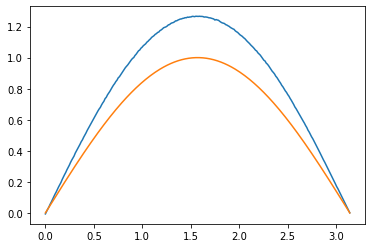

In [13]:
with torch.no_grad():
    prediction = lem(test_tensor)
    prediction = prediction.view(1, 1, 256).float()
    prediction_tensor[:, 0, :] = prediction
    for i in range(19):
        prediction = lem(prediction)
        prediction = prediction.view(1, 1, 256).float()
        prediction_tensor[:, i+1, :] = prediction
        



final_out = prediction.detach().numpy().reshape(-1,1)
final_true = u_exact[-1,:].reshape(-1,1)


x = x.reshape(-1, 1)

plt.plot(x, final_out)
plt.plot(x, final_true)
plt.show()

In [14]:
prediction_tensor.shape

torch.Size([1, 20, 256])

(256, 1)
torch.Size([256, 1])


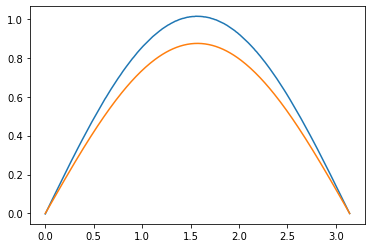

In [15]:


final_out = prediction_tensor[:, -5].detach().numpy().reshape(-1,1)
final_true = u_exact[-5,:].reshape(-1,1)

print(final_out.shape)
print(final_true.shape)

x = x.reshape(-1, 1)

plt.plot(x, final_out)
plt.plot(x, final_true)
plt.show()

In [16]:
prediction_tensor.shape
prediction_tensor = torch.squeeze(prediction_tensor)
print(prediction_tensor.shape)

torch.Size([20, 256])


In [17]:
# Exact Solution

u_test = u_exact
u_test_full = u_test[80:100, :]

### L2 norm

In [18]:
# Extrapolation

k1 = ( prediction_tensor - u_test_full)**2
u_test_full_tensor = u_test_full**2
u_test_full_tensor.shape

torch.Size([20, 256])

In [19]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(k1)/ torch.mean(u_test_full_tensor)

print("Relative Error Test: ", relative_error_test.item(), "%")

Relative Error Test:  0.05938947695517928 %


### Maximum absolute 

In [20]:
R_abs = torch.max(torch.abs(prediction_tensor - u_test_full))
print(R_abs)

tensor(0.2673, dtype=torch.float64)


### Explained variance score

In [21]:
import torch

a = prediction_tensor
b = u_test_full
# Assuming 'a' is your predicted values (model's predictions) and 'b' is the true values (ground truth)
# Make sure 'a' and 'b' are PyTorch tensors


# Calculate the mean of 'b'
mean_b = torch.mean(b)

# Calculate the Explained Variance Score
numerator = torch.var(b - a)  # Variance of the differences between 'b' and 'a'
denominator = torch.var(b)    # Variance of 'b'
evs = 1 - numerator / denominator

print("Explained Variance Score:", evs.item())

Explained Variance Score: 0.94097300462909


### mean absolute error

In [22]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(torch.abs(prediction_tensor - u_test_full))

print("Relative Error Test: ", relative_error_test, "%")


Relative Error Test:  tensor(0.0915, dtype=torch.float64) %


In [23]:
print(prediction_tensor.shape)

torch.Size([20, 256])


In [24]:
prediction.shape

torch.Size([1, 1, 256])

In [25]:
x1 = np.linspace(0, pi, 256)
t1 = np.linspace(0, 1, 99)

conc_u = torch.squeeze(input_tensor)
concatenated_tensor = torch.cat((conc_u, prediction_tensor), dim=0)


### Contour 80-20

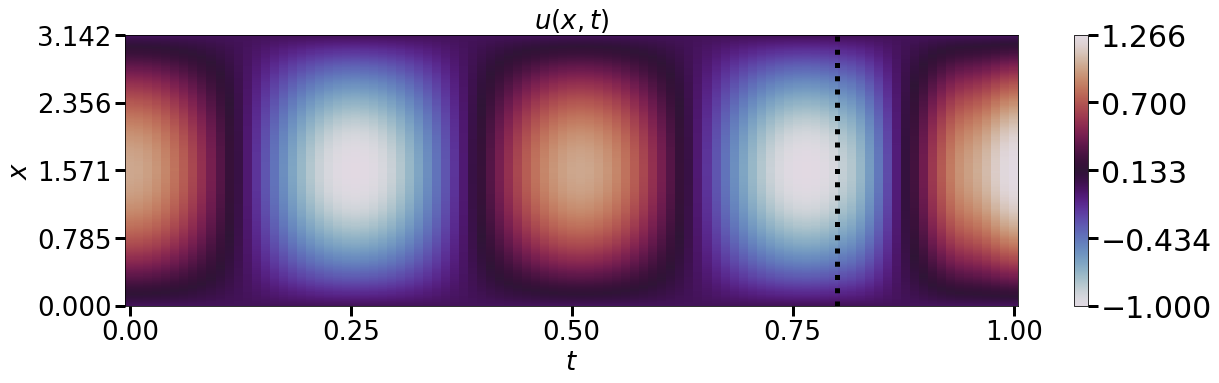

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()

# Define custom color levels
x = np.linspace(0, 1, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x1, t1)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='twilight')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$u(x, t)$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

# Add a dotted line at t = 0.8
plt.axvline(x=0.8, color='black', linestyle='dotted', linewidth=5)

#plt.savefig('Contour_LEM_20.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_LEM_20.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


### snapshots

In [27]:
print(prediction_tensor.shape)

torch.Size([20, 256])


In [28]:
print(u_exact.shape)

torch.Size([100, 256])


In [29]:
x = np.linspace(0, pi, 256)
t = np.linspace(0, 1, 100)
t[-2]

0.98989898989899

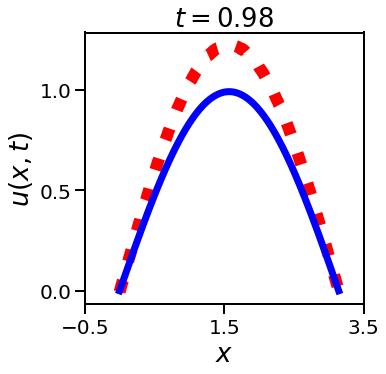

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed



final_time_output = prediction_tensor[-2, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u_exact[-2, :].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')


# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.98}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-0.5, 1.5, 3.5])
ax.set_yticks([0, 0.5, 1])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set the legend
# ax.legend()

plt.savefig('LEM_0.98_20.pdf', dpi=500, bbox_inches="tight")
#plt.savefig('lem_0.98_20.png', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


In [31]:
print(prediction_tensor.shape)

torch.Size([20, 256])


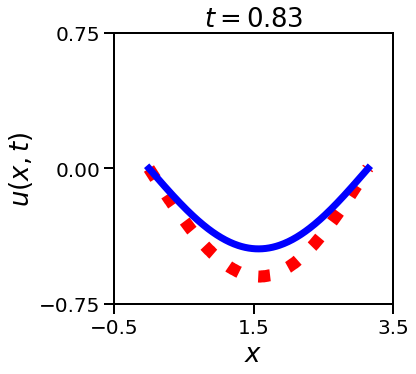

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed



final_time_output = prediction_tensor[3, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u_exact[83, :].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')


# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.83}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-0.5, 1.5, 3.5])
ax.set_yticks([-0.75, 0, 0.75])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set the legend
# ax.legend()

plt.savefig('LEM_0.83_20.pdf', dpi=500, bbox_inches="tight")
#plt.savefig('lem_0.98_20.png', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()
